# <span style='color:SteelBlue'>P4 - Anticipez les besoins en consommation de bâtiments (2ème partie)</span>

# <span style='background:orange; color:black'>Prédiction consommation totale d'énergie</span>

![Logo Seattle](https://login.seattle.gov/static/media/logo.62be6fde.jpg)

# <span style='background:white; color:black'>Sommaire</span>

**Introduction**

Importations des librairies utilisées dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisées dans ce notebook <br>

Importation du dataset <br>

**Etape 1 : Description des données**
- _1/ Origine des données_
- _2/ Respect du RGPD_
- _3/ Aperçu tableau_
- _4/ Structure_
- _5/ Valeurs manquantes_
- _6/ Inspection des données_<br>

**Etape 2 : Feature Engineering**
- _1/ Renommage feature cible_
- _2/ Séparation des features explicatives et de la feature cible_
- _3/ Séparation des jeux d'entrainement et de test_
- _4/ Pré-traitement : encodage et standardisation_<br>

**Etape 3 : Modélisation**
- _1/ Modèle de régression naïf_
- _2/ Modèles linéaires_
  - ElasticNet
  - SVR
- _3/ Modèles non-linéaires_
  - RandomForest
  - GradientBoosting
- 4/ Choix du modèle le plus adpaté<br>

**Etape 4 : Feature importance**
- _1/ Feature importance globale_
- _2/ Feature importance locale_<br>

**Etape 5 : Etude de l'apport du score ENERGY STAR**
- _1/ Performance du modèle SANS le score ENERGY STAR imputé_
- _2/ Performance du modèle AVEC le score ENERGY STAR incomplet_
- _3/ Performance du modèle SANS le score ENERGY STAR incomplet_
- _4/ Comparaison des résultats des différents datasets_<br>

**Etape 6 : Courbe d'apprentissage**

**Conclusion**

# <span style='background:blue'>Introduction</span>

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation puisqu'ils génère 33% des émissions de CO2 de la ville. Cette dernière a ainsi adopté un plan d'action climatique en 2013. Un relevé annuel des batiment de la ville permet de suivre l'évolution de leurs performances énergétiques. 

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émission de CO2 et la consommation totale d'énergie des batiments. 

___

**Mission**

**Prédire les émissions de CO2 et la consommation totale d’énergie** non-mesurées de bâtiments non destinés à l’habitation de la ville de Seattle à partir d’un dataset de la ville. Pour cela je devrais :
1.  Réaliser une courte analyse exploratoire.
2.  Tester différents modèles de prédiction pour prédire la consommation totale d'énergie.
3.  Tester différents modèles de prédiction pour prédire les émissions de CO2.

Ce notebook présente la 2ème partie. Plus particulièrement, nous y présenterons les 4 modèles de prédiction que nous avons testés et les résultats obtenus pour la **prédiction de la consommation totale d'énergie** : 
- ElasticNet
- SVM
- GradientBoosting
- RandomForest

___

**Source des datasets**<br>
[Seattle Open Data](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)<br>

1 fichier CSV source:
- 2016_Building_Energy_Benchmarking.csv

1 fichier CSV nettoyé:
- 2016_Building_Energy_Benchmarking_cleaned.csv
___


# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [119]:
# Librairies diverses
import datetime
import os
import os.path
import sys
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy
import time
import warnings
from IPython.display import display   

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Modèle de régression naïf
from sklearn.dummy import DummyRegressor

# Modèles linéaires
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Modèles non-linéaires
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Feature importance 
import shap
from sklearn.inspection import permutation_importance

# Learning curve
from sklearn.model_selection import learning_curve

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('Missingno     : ' + msno.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)
print('Shap          : ' + shap.__version__)
print('Sklearn       : ' + sklearn.__version__)

# Afficher heure lancement
maintenant = datetime.datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

Version des librairies utilisées :
Python        : 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
Matplotlib    : 3.8.0
Missingno     : 0.5.2
NumPy         : 1.26.0
Pandas        : 2.1.1
Scipy         : 1.11.3
Seaborn       : 0.13.0
Shap          : 0.43.0
Sklearn       : 1.3.1

Code lancé le : 2023-11-30T09:34:56.136634


# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [120]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

In [121]:
# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

In [122]:
# Nombre de coeurs
num_cores = os.cpu_count()
print(f"Number de coeur disponibles sur ce PC: {num_cores} coeur(s)")

Number de coeur disponibles sur ce PC: 12 coeur(s)


# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

In [123]:
# #                            SUPPRIMER OUTLIERS IQR
# # ****************************************************************************

def histo_interval_feat_continue(df_data, feature_cible, nb_bins=7, normalisation=False):
    
    """
    Procédure qui crée un histogramme d'une variable continue discrétisée en intervalles.
    
    :param df_data : DataFrame contenant les données (df)
    :param feature_cible : Le nom de la colonne à représenter (str)
    :param nb_bins : nombre de bins (intervalles) pour discrétiser la variable (par défaut 7)(int, optional)
    :param normalisation : normalisation des fréquences (par défaut False)(bool, optional)
    """
    
    # Création des intervalles
    bin_edges = np.linspace(min(df_data[feature_cible]), max(df_data[feature_cible]), nb_bins)
    
    # Discrétisation de la variable continue en catégories
    categories = pd.cut(df_data[feature_cible], bin_edges, right=True)
    
    # Comptage des occurrences dans chaque catégorie
    value_counts = categories.value_counts().sort_index()
    
    # Utilisez les valeurs du milieu des intervalles comme positions sur l'axe x
    x_positions = [(interval.left + interval.right) / 2 for interval in value_counts.index]
    
    # Utilisez les fréquences comme hauteurs des barres
    bar_heights = value_counts.values.tolist()
    
    # Largeur des bins
    largeur = (max(df_data[feature_cible]) - min(df_data[feature_cible]) + 1) / nb_bins 
    
    # SI on veut normaliser avec des pourcentages
    if normalisation:
        
        # Convertissez les fréquences en pourcentage
        total_observations = len(df_data)
        value_percentages = (value_counts / total_observations) * 100
        
        # Créez un histogramme à partir des catégories
        plt.bar(x_positions, value_percentages, width=largeur, edgecolor='k')
        plt.ylabel('Fréquence (%)')
    
    # SINON on veut des nombres
    else:
        plt.bar(x_positions, bar_heights, width=largeur, edgecolor='k')
        plt.ylabel('Fréquence (nombre)')
    
    # Ajoutez des titres et des étiquettes d'axe
    plt.title(f'Histogramme de {feature_cible}')
    plt.xlabel(feature_cible)
    
    plt.show()

In [124]:
# #                            GRID SEARCH MODEL
# # ****************************************************************************

def grid_search_model(X_train, y_train, model, param_grid, cv=5, n_jobs=-1):
    """
    Fonction qui effectue une recherche par grille (Grid Search) pour trouver les meilleurs paramètres d'un modèle.

    :param X_train: Données d'entraînement
    :param y_train: Labels d'entraînement
    :param model: Modèle à optimiser (ElasticNet, SVR, RandomForest, XGBoost, etc.)
    :param param_grid: Grille des hyperparamètres à explorer
    :param cv: Nombre de plis pour la validation croisée (par défaut 5)
    :param n_jobs: Nombre de cœurs CPU à utiliser (-1 pour utiliser tous les cœurs, par défaut -1)

    :return: Meilleurs paramètres, meilleur score et temps de calcul
    """
    # Mesure du temps de départ
    start_time = time.time()
    
    # Création de la grid search du modèle
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=n_jobs, return_train_score=True, verbose=1)
    
    # Entraînement de la grid search
    grid_search.fit(X_train, y_train)
    
    # Mesure du temps de fin
    end_time = time.time()
    
    # Calcul du temps d'exécution
    grid_search_time = end_time - start_time
    
    # Affichage des résultats
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("\nBest parameters:", best_params)
    print("Best score:", best_score)
    print("Temps d'éxecution grid_search (seconds):", round(grid_search_time, 2), "\n")
    
    # Création d'un dictionnaire pour stocker les résultats
    grid_search_resultats = {
        'best_params': best_params,
        'best_score': best_score,
        'grid_search_time': round(grid_search_time, 2)
    }
    
    # Outputs
    return grid_search, grid_search_resultats

In [125]:
# #                            CALCULE METRICS
# # ****************************************************************************

def calcule_metrics(y_true, y_pred):
    """
    Fonction pour calculer l'Erreur Quadratique Moyenne (MSE), la Racine Carrée de l'Erreur Quadratique Moyenne (RMSE), et le coefficient de détermination (R2) des prédictions du modèle.
    
    :param y_true: Les valeurs réelles (numpy array ou pandas series)
    :param y_pred: Les valeurs prédites par le modèle (numpy array ou pandas series)
    
    :return: mse (float), rmse (float), r2 (float)
    """
    
    # Calcule de l'erreur quadratique moyenne (MSE)
    mse = mean_squared_error(y_true, y_pred).round(2) # type: ignore
    
    # Calcule de la racine carrée de l'erreur quadratique moyenne (RMSE)
    rmse = np.sqrt(mse).round(2)
    
    # Calcule du coefficient de détermination (R2)
    r2 = r2_score(y_true, y_pred).round(2)  # type: ignore
    
    # Outputs
    return mse, rmse, r2

In [126]:
# #                            EVAL MODELE
# # ****************************************************************************

def eval_modele(grid_search_modele, X_train, X_test, y_train, y_test):
    """
    Fonction pour évaluer un modèle de régression. Elle calcule le MSE, le RMSE, le R² et le temps d'exécution pour l'entraînement et la prédiction.
    
    :param grid_search_modele: Objet GridSearchCV
    :param X_train: Données d'entraînement (df)
    :param X_test: Données de test (df)
    :param y_train: Feature cible d'entraînement (df)
    :param y_test: Feature cible de test (df)
    
    :return: results (dict)
    :return: modele entrainé sur les données d'entrainement (modele)
    """
    
    # Si le modèle est un DummyRegressor
    if grid_search_modele is dummy_regr:    # type: ignore
        modele = grid_search_modele
    
    # Sinon Sélection des hyperparamètres du meilleur modèle selon GridSearchCV
    else:
        modele = grid_search_modele.best_estimator_
    
    # Entraînement du modèle sur les données d'entraînement
    start_fit_time = time.time()
    modele.fit(X_train, y_train)
    temps_fit = round(time.time() - start_fit_time, 2)
    
    # Prédiction sur les données d'entraînement et de test
    start_predict_time = time.time()
    y_pred_train = modele.predict(X_train)
    y_pred_test = modele.predict(X_test)
    temps_predict = round(time.time() - start_predict_time, 2)
    
    # Calcul des métriques
    mse_train, rmse_train, r2_train = calcule_metrics(y_train, y_pred_train)
    mse_test, rmse_test, r2_test = calcule_metrics(y_test, y_pred_test)
    
    # Dictionnaire des résultats
    results = {
        'mse_train': mse_train,
        'mse_test': mse_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r²_train': r2_train,
        'r²_test': r2_test,
        'temps_fit (sec)': temps_fit,
        'temps_predict (sec)': temps_predict}
    
    # Affichage des résultats
    for i, (key, value) in enumerate(results.items()):
        print(f"{key} : {value}")
        
        # Ajouter une ligne de séparation entre chaque métrique
        if i % 2 != 0: 
            print('_' * 50)
    
    # Outputs
    return results, modele

In [127]:
# #                            SHAP PLOT AVEC COULEUR
# # ****************************************************************************

def shap_plot_avec_couleur(df_shap, df, n=20):
    """
    Cette procédure calcule et affiche les valeurs SHAP absolues pour les caractéristiques d'un modèle de ML.
    
    Paramètres :
    df_shap (DataFrame) : DataFrame contenant les valeurs SHAP.
    df (DataFrame) : DataFrame contenant les données d'origine.
    n (int) : Nombre de features à afficher. Par défaut, 20.
    """
    
    # Ignorer les avertissements
    warnings.filterwarnings("ignore")
    
    # Préparation des données
    shap_v = pd.DataFrame(df_shap, columns=df.columns)
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Calcul de la corrélation
    corr_list = [np.corrcoef(shap_v[i], df_v[i])[1][0] for i in df.columns]
    corr_df = pd.DataFrame({'Variable': df.columns, 'Corr': corr_list}).fillna(0)
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'red', 'blue')
    
    # Calcul des valeurs SHAP absolues
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame({'Variable': df.columns, 'SHAP_abs': shap_abs.mean()})
    k2 = k.merge(corr_df, on='Variable').sort_values(by='SHAP_abs', ascending=True)
    
    # Tronquer le DataFrame aux n dernières lignes
    k2_top = k2.tail(n)
    
    # Affichage du graphique
    ax = k2_top.plot.barh(x='Variable', y='SHAP_abs', color=k2_top['Sign'], figsize=(15, 8), legend=False)  # type: ignore
    
    # Ajout des étiquettes de données à droite des barres
    for i in ax.patches:
        ax.text(i.get_width() + .01, i.get_y(), \
                str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')   # type: ignore
    
    # Titre de l'axe des x et grille
    ax.set_xlabel("Valeur de Shapley (Rouge = corrélation positive)", fontdict=font_axe)
    ax.set_title("Corrélation des valeurs de Shapley", fontdict=font_title)
    plt.grid(True, which='both', axis='x')

In [128]:
# #                            PLOT DISTRIBUTION
# # ****************************************************************************

def plot_distribution(df, col, color, binwidth=None, shapiro_wilk=False, unit=None):
    """
    Procédure qui affiche la distribution de la colonne sous forme d'histogramme et une boîte à moustaches.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param color: couleur pour l'histogramme (str)
    :param binwidth: largeur des barres de l'histogramme (int or float) (optionnel)
    :param shapiro_wilk: Effectuer le test de Shapiro-Wilk (booléen) (optionnel)
    :param unit: Unités pour l'axe X (str) (optionnel)
    """
    
    # Création de sous-plots pour l'histogramme et la boîte à moustaches
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # SI le test de Shapiro-Wilk est effectué
    if shapiro_wilk:

        # Effectuez test de S-W et écrire le résultat dans le titre du graphique
        sw_statistic, p_value = shapiro(df[col])
        sw_texte = "Distribution '{0}' Test S-W :{1:.2f} / p-value = {2:.2f}".format(col, sw_statistic, p_value)
        axes[0].set_title(sw_texte, fontdict=font_title, fontsize=14)
    else:
        # SI pas de test de Shapiro-Wilk, affichage titre par défaut
        axes[0].set_title("Distribution '{0}'".format(col), fontdict=font_title)
    
    # Graphique de l'histogramme
    if binwidth is not None:
        sns.histplot(df[col], kde=True, color=color, binwidth=binwidth, ax=axes[0])
    else:
        sns.histplot(df[col], kde=True, color=color, ax=axes[0])
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[0].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[0].set_xlabel("Valeur", fontdict=font_axe)
    
    # Graphique de la boîte à moustaches
    sns.boxplot(x=df[col], color=color, ax=axes[1])
    axes[1].set_title("Boxplot '{0}'".format(col), fontdict=font_title)
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[1].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[1].set_xlabel("Valeur", fontdict=font_axe)
    
    # Ajustement de l'espacement entre les sous-plots
    plt.tight_layout()
    
    # Affichage des graphiques
    plt.show()

In [129]:
# #                            SUPPRIMER OUTLIERS IQR
# # ****************************************************************************

def supprimer_outliers_iqr(df, feature, seuil=1.5):
    """
    Fonction qui supprime les outliers d'un DataFrame en utilisant la méthode IQR (Interquartile Range): toutes les valeurs situées en dehors de la plage [Q1 - seuil * IQR, Q3 + seuil * IQR] sont considérées comme des outliers et sont supprimées du DataFrame. Par défaut, le seuil est de 1,5.
    
    :param df: Le DataFrame à nettoyer (pd.DataFrame).
    :param seuil: Le facteur d'échelle pour déterminer la limite IQR (par défaut 1.5) (float).
    
    :return: Le DataFrame nettoyé sans les outliers (pd.DataFrame).
    """
    
    # Calculer les quartiles
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    # Calculer l'écart interquartile (IQR)
    IQR = Q3 - Q1
    
    # Définir la plage IQR pour chaque colonne
    borne_inferieure = Q1 - seuil * IQR
    borne_superieure = Q3 + seuil * IQR
    
    # Identifiez les lignes avec des outliers
    lignes_outliers = df.loc[(df[feature] < borne_inferieure) | (df[feature] > borne_superieure)]
    
    # Supprimez les lignes avec des outliers
    df_sans_outliers = df.drop(index=lignes_outliers.index)
    
    # Réinitialiser l'index
    df_sans_outliers = df_sans_outliers.reset_index(drop=True)
    
    # Outputs
    return df_sans_outliers

In [130]:
# #                            CONDITIONAL SCALER
# # ****************************************************************************

class ConditionalScaler(BaseEstimator, TransformerMixin):
    """
    Cette classe est un transformateur personnalisé qui applique un scaler différent à chaque colonne en fonction de ses caractéristiques. Les colonnes avec des outliers sont mises à l'échelle avec RobustScaler, 
    les colonnes normalement distribuées sont mises à l'échelle avec StandardScaler, et les autres colonnes sont mises à l'échelle avec MinMaxScaler.
    """
    
    """
    Constructeur de la classe. Prend en entrée une liste de noms de colonnes sur lesquelles appliquer le scaling.
    """
    def __init__(self, columns):
        self.columns = columns
        self.scalers = {}
    
    """
    Méthode pour l'entraînement du modèle. Pour chaque colonne, elle calcule les z-scores et effectue le test de Shapiro pour déterminer quel scaler utiliser. Ensuite, elle entraîne le scaler.
    """
    def fit(self, X, y=None):
    
        # POUR chaque colonne
        for i, column in enumerate(self.columns):
            x = X[:, i].reshape(-1, 1) 
            
            # Test de Shapiro
            _, p = shapiro(x)
            
            # SI Shapiro test OK, utiliser StandardScaler
            if p > 0.05: 
                self.scalers[column] = StandardScaler()
            
            # SI test Shapiro pas OK, utiliser MinMaxScaler
            else:
                self.scalers[column] = MinMaxScaler()
            
            # Calcul des z-scores
            z_scores = np.abs(zscore(x, nan_policy='omit'))
            
            # SI z-scores > 3, utiliser RobustScaler
            if np.any(z_scores > 3):  # Seuil pour les outliers
                self.scalers[column] = RobustScaler()
            
            # Entraînement du scaler
            self.scalers[column].fit(x)
            
            # Affichage du type de scaler utilisé
            print(f"'{column}' => utilisation de '{type(self.scalers[column]).__name__}'")
        
        # output
        return self
    
    """
    Méthode pour la transformation des données. Pour chaque colonne, elle applique le scaler correspondant.
    """
    def transform(self, X):
        output = np.empty_like(X)
        
        # POUR chaque colonne, appliquer le scaler
        for i, column in enumerate(self.columns):
            x = X[:, i].reshape(-1, 1)
            output[:, i] = self.scalers[column].transform(x).flatten()
        return output

In [131]:
# #                            FEATURE IMPORTANCE GLOBALE
# # ****************************************************************************

def feature_importance_globale(preprocessor, X_train_transformed, X_test_transformed, model):
    """
    Procédure qui calcule et affiche les valeurs SHAP pour un modèle donné.
    
    Paramètres :
    preprocessor (objet préprocesseur) : Le préprocesseur utilisé pour transformer les données.
    X_train_transformed (csr_matrix) : Les données d'entraînement transformées.
    X_test_transformed (csr_matrix) : Les données de test transformées.
    model (objet modèle) : Le modèle pour lequel les valeurs SHAP doivent être calculées.
    
    Retourne :
        X_test_transformed_df (df) : Les données d'entraînement transformées en df.
    """
    
    # Obtenir les noms des caractéristiques après la transformation
    noms_des_features = preprocessor.get_feature_names_out()
    
    # Convertir csr_matrix en tableau numpy
    X_train_transformed_array = X_train_transformed.toarray()
    X_test_transformed_array = X_test_transformed.toarray()
    
    # Transformer les données de test en DataFrame
    X_test_transformed_df = pd.DataFrame(X_test_transformed_array, columns=noms_des_features)
    
    # Initialiser l'explainer (avec les données d'entrainement)
    explainer = shap.TreeExplainer(model, X_train_transformed_array)
    
    # Calculer les valeurs SHAP (avec les données de test)
    shap_values = explainer.shap_values(X_test_transformed_array)
    
    # Afficher les valeurs SHAP selon leur correlation avec la variable cible
    shap_plot_avec_couleur(shap_values, X_test_transformed_df)
    
    # output
    return X_test_transformed_df, shap_values

In [132]:
# #                            FEATURE IMPORTANCE LOCALE
# # ****************************************************************************

def feature_importance_locale(model, X, y, n_repeats=10, random_state=42, n_jobs=-1):
    """
    Fonction qui calcule et affiche l'importance des caractéristiques du modèle donné en utilisant la méthode de permutation.
    
    Paramètres :
    model (objet modèle) : Le modèle pour lequel l'importance des caractéristiques doit être calculée.
    X (DataFrame) : Les données d'entrée des features explicatives.
    y (Series ou array) : Les données de sortie de la target.
    n_repeats (int, optionnel) : Le nombre de fois à répéter la permutation. Par défaut à 10.
    random_state (int, optionnel) : La graine pour le générateur de nombres aléatoires. Par défaut à 42.
    n_jobs (int, optionnel) : Le nombre de tâches à exécuter en parallèle. Par défaut à -1, ce qui signifie utiliser tous les processeurs disponibles.
    
    Retourne :
    DataFrame : Un DataFrame contenant les caractéristiques et leur importance, trié par importance décroissante.
    """
    
    # Calcul de l'importance des caractéristiques par permutation
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs)
    
    # Récupération des importances et des noms des caractéristiques
    importances = result.importances_mean   # type: ignore
    features = X.columns.to_list()
    
    # Création d'un DataFrame pour l'importance des caractéristiques
    importance_df = pd.DataFrame({'feature': features, 'importance': importances})
    
    # Tri et affichage des 10 caractéristiques les plus importantes
    return importance_df.sort_values(by='importance', ascending=False).head(10)

In [133]:
# #                            COMPARE PERF
# # ****************************************************************************

def compare_perf(df_resultats_eval_modele, perf_type, diff_type, font_title, font_axe, features):
    """
    Procédure qui trace un histogramme de la performance (RMSE, r² ou temps) pour différents modèles.
    
    Paramètres :
    df_resultats_eval_modele (DataFrame) : DataFrame contenant les résultats des modèles.
    perf_type (str) : Type de performance à afficher ('rmse', 'r²' ou 'temps').
    diff_type (str) : Type de différence à afficher.
    font_title (dict) : Dictionnaire définissant le style du titre du graphique.
    font_axe (dict) : Dictionnaire définissant le style des axes du graphique.
    features (list) : Liste des caractéristiques à inclure dans le graphique.
    
    Retourne :
    None
    """
    # Histogramme des MSE pour les modèles
    ax = df_resultats_eval_modele[features].plot(kind='bar')
    
    # Définir le titre et les labels de l'axe Y
    # RMSE
    if perf_type == 'rmse':
        plt.title("Comparaison de l'erreur quadratiques moyenne (RMSE) de {0}".format(diff_type), fontdict=font_title)
        plt.ylabel("RMSE (en kBtu)", fontdict=font_axe)
    
    # r²
    elif perf_type == 'r²':
        plt.title("Comparaison du coefficient de détermination (r²) de {0}".format(diff_type), fontdict=font_title)
        plt.ylabel("r² (en %)", fontdict=font_axe)
    
    # Temps
    elif perf_type == 'temps':
        plt.title("Comparaison du temps d'entrainement et de prédiction de {0}".format(diff_type), fontdict=font_title)
        plt.ylabel("Temps (en sec)", fontdict=font_axe)
        
    plt.xlabel("{0}".format(diff_type), fontdict=font_axe)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc="best", bbox_to_anchor=(1.3, 1))
    
    # Ajouter les étiquettes de données
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')
    plt.show()

In [134]:
# #                            CALCULER COURBE APPRENTISSAGE
# # ****************************************************************************

def calculer_courbe_apprentissage(model, X_train, y_train):
    """
    Fonction qui calcule la courbe d'apprentissage pour un modèle donné et un ensemble d'entraînement.
    
    Args:
    model (estimator): Le modèle à entraîner.
    X_train (array-like): Les données d'entraînement.
    y_train (array-like): Les cibles d'entraînement.
    
    Returns:
    train_sizes (array): Les tailles d'entraînement utilisées pour la courbe d'apprentissage.
    train_mean (array): La moyenne des scores d'entraînement pour chaque taille.
    test_mean (array): La moyenne des scores de validation pour chaque taille.
    train_std (array): L'écart-type des scores d'entraînement pour chaque taille.
    test_std (array): L'écart-type des scores de validation pour chaque taille.
    """
    
    # Calculer la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve( # type: ignore
        estimator=model,
        X=X_train,
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 50),
        cv=10,
        scoring='r2',
        n_jobs=-1,
        verbose=1)
    
    # Calculer la moyenne pour les données d'entrainement et de test
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    
    # Calculer l'écart-type pour les données d'entrainement et de test
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)
    
    # Outputs
    return train_sizes, train_mean, test_mean, train_std, test_std

In [135]:
# #                            TRACER COURBE APPRENTISSAGE
# # ****************************************************************************

def tracer_courbe_apprentissage(train_sizes, train_mean, test_mean, train_std, test_std, model, font_title, font_axe):
    """
    Procédure qui trace la courbe d'apprentissage pour un modèle donné.
    
    Args:
    train_sizes (array): Les tailles d'entraînement utilisées pour la courbe d'apprentissage.
    train_mean (array): La moyenne des scores d'entraînement pour chaque taille.
    test_mean (array): La moyenne des scores de validation pour chaque taille.
    train_std (array): L'écart-type des scores d'entraînement pour chaque taille.
    test_std (array): L'écart-type des scores de validation pour chaque taille.
    model (estimator): Le modèle pour lequel la courbe d'apprentissage est tracée.
    font_title (dict): Le style de police pour le titre du graphique.
    font_axe (dict): Le style de police pour les axes du graphique.
    """
    
    # Créer une nouvelle figure
    plt.figure()
    
    # Tracer les courbes des scores d'entraînement et de test
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score de test")
    
    # Tracer la zone d'incertitude pour les scores d'entraînement et de validation croisée
    plt.fill_between(train_sizes, train_mean - train_std,
                    train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std,
                    test_mean + test_std, alpha=0.1, color="g")
    
    # Ajouter une légende, un titre, une giller et des étiquettes d'axe
    plt.title("Courbe d'apprentissage pour le modèle {0}".format(type(model).__name__), fontdict=font_title)
    plt.xlabel("Nombre de bâtiments d'entraînement", fontdict=font_axe)
    plt.ylabel("r²", fontdict=font_axe)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [136]:
# #                            TRACER COURBE APPRENTISSAGE
# # ****************************************************************************

def tracer_gap_apprentissage(train_sizes, gap, model, font_title, font_axe):
    """
    Procédure qui trace le gap d'apprentissage pour un modèle donné.
    
    Args:
    train_sizes (array): Les tailles d'entraînement utilisées pour la courbe d'apprentissage.
    gap (array): Le gap d'apprentissage pour chaque taille d'entraînement.
    model (estimator): Le modèle pour lequel le gap d'apprentissage est tracé.
    font_title (dict): Le style de police pour le titre du graphique.
    font_axe (dict): Le style de police pour les axes du graphique.
    """
    
    # Tracer le gap d'apprentissage
    plt.plot(train_sizes, gap, 'o-', color="b", label="Gap")
    
    # Ajouter une légende, un titre, une gille et des étiquettes d'axe
    plt.title("Gap d'apprentissage pour le modèle {0}".format(type(model).__name__), fontdict=font_title)
    plt.xlabel("Nombre de bâtiments d'entraînement", fontdict=font_axe)
    plt.ylabel("Gap (%)", fontdict=font_axe)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# <span style='background:grey'>Importation du dataset</span>

Importation du fichier CSV avec Pandas

In [137]:
# chemin et nom du fichier nettoyé
path = "./data/cleaned/"
csv_nomFichier = '2016_Building_Energy_Benchmarking_cleaned.csv'

# Importation du fichier 
df_data = pd.read_csv(path + csv_nomFichier, sep="\t", encoding='utf-8')

# <span style='background:blue'>Etape 1 : Description des données</span>
___

1 fichier : **2016_Building_Energy_Benchmarking_cleaned.csv**

## <span style='background:green'>1/ Origine des données</span>

- **Créateur des données** : Pierrick BERTHE

- **Méthode de collecte des données** : non-précisé

- **Type du fichier** : fichier CSV

- **Taille du fichier** : 316 Ko

- **Date de dernière modification des données du fichier** : 29 novembre 2023

## <span style='background:green'>2/ Respect du RGPD</span>

Le RGPD ne s'applique que sur les données personnelles qui concernent des résidents de l'Union Européenne. Ce qui n'est pas le cas ici.

A noter qu'il existe la Washington State Privacy Act (WPA) qui protège les données personnelles des résidents de l'Etat de Washington. Cependant, les données de ce dataset ne concernent pas des personnes mais des bâtiments.

**Ces données ne sont donc pas soumises au RGPD et sont donc totalement exploitables**.

## <span style='background:green'>3/ Aperçu tableau</span>

Nous affichons les 5 premières lignes du fichier CSV.

In [138]:
df_data.head()

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,60.0,60.0,15.79325,False,Compliant,5.52537,2.83,0.54606,0.27730,0.17664,89
1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,61.0,61.0,15.94230,False,Compliant,5.69326,2.86,0.38661,0.00000,0.61339,20
2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,43.0,43.0,18.10030,False,Compliant,7.64505,2.19,0.68231,0.29711,0.02058,47
3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1.0,Hotel,61320.0,56.0,56.0,15.73164,False,Compliant,5.66098,4.67,0.40752,0.32591,0.26657,90
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,1.0,Hotel,123445.0,75.0,75.0,16.46682,False,Compliant,6.22656,2.88,0.37880,0.00000,0.62120,36


Nous affichons les 5 dernières lignes du fichier CSV.

In [139]:
df_data.tail()

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
1605,Nonresidential COS,Office,Horticulture building,GREATER DUWAMISH,1.0,Office,12294.0,46.0,46.0,13.65269,True,Error - Correct Default Data,3.08831,1.70,0.61697,0.0,0.38303,26
1606,Nonresidential COS,Other,International district/Chinatown CC,DOWNTOWN,1.0,Other - Recreation,16000.0,NaN,76.0,13.76451,False,Compliant,3.50165,2.01,0.41730,0.0,0.58270,12
1607,Nonresidential COS,Other,Queen Anne Pool,MAGNOLIA / QUEEN ANNE,1.0,Other - Recreation,7583.0,NaN,12.5,15.56747,False,Compliant,5.41405,16.99,0.31082,0.0,0.68918,42
1608,Nonresidential COS,Mixed Use Property,South Park Community Center,GREATER DUWAMISH,1.0,Other - Recreation,6601.0,NaN,87.0,13.48627,False,Compliant,3.14027,1.57,0.48490,0.0,0.51510,27
1609,Nonresidential COS,Mixed Use Property,Van Asselt Community Center,GREATER DUWAMISH,1.0,Other - Recreation,8271.0,NaN,47.5,13.95779,False,Compliant,3.74408,2.26,0.37519,0.0,0.62481,78


Nous affichons une ligne au hasard du fichier CSV.

In [140]:
df_data.sample()

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
821,NonResidential,Other,(ID#21221) KC Metro Transit North Facilities M...,NORTHWEST,1.0,Other - Public Services,19050.0,NaN,52.0,14.0045,False,Compliant,3.52223,1.57,0.56158,0.0,0.43841,7


## <span style='background:green'>4/ Structure</span>

Nous affichons les informations sur les colonnes du fichier CSV.

In [141]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1610 non-null   object 
 1   PrimaryPropertyType        1610 non-null   object 
 2   PropertyName               1610 non-null   object 
 3   Neighborhood               1610 non-null   object 
 4   NumberofBuildings          1610 non-null   float64
 5   LargestPropertyUseType     1610 non-null   object 
 6   LargestPropertyUseTypeGFA  1610 non-null   float64
 7   ENERGYSTARScore            1068 non-null   float64
 8   ENERGYSTARScore_KNN        1610 non-null   float64
 9   SiteEnergyUse(kBtu)        1610 non-null   float64
 10  DefaultData                1610 non-null   bool   
 11  ComplianceStatus           1610 non-null   object 
 12  TotalGHGEmissions          1610 non-null   float64
 13  GHGEmissionsIntensity      1610 non-null   float

Nous comptons le nombre de feature selon les types de données.

In [142]:
df_data.dtypes.value_counts()

float64    10
object      6
bool        1
int64       1
Name: count, dtype: int64

Nous comptons le nombre de valeurs différentes pour chaque feature.

In [143]:
df_data.nunique()

BuildingType                    5
PrimaryPropertyType            22
PropertyName                 1606
Neighborhood                   19
NumberofBuildings              13
LargestPropertyUseType         55
LargestPropertyUseTypeGFA    1512
ENERGYSTARScore               100
ENERGYSTARScore_KNN           177
SiteEnergyUse(kBtu)          1610
DefaultData                     2
ComplianceStatus                2
TotalGHGEmissions            1544
GHGEmissionsIntensity         449
Electricity_Proportion       1498
SteamUse_Proportion           109
NaturalGas_Proportion        1164
AncienneteBatiment            113
dtype: int64

## <span style='background:green'> 5/ Valeurs manquantes</span>

Nous affichons le nombre de valeurs manquantes par feature.

In [144]:
df_data.isna().sum()

BuildingType                   0
PrimaryPropertyType            0
PropertyName                   0
Neighborhood                   0
NumberofBuildings              0
LargestPropertyUseType         0
LargestPropertyUseTypeGFA      0
ENERGYSTARScore              542
ENERGYSTARScore_KNN            0
SiteEnergyUse(kBtu)            0
DefaultData                    0
ComplianceStatus               0
TotalGHGEmissions              0
GHGEmissionsIntensity          0
Electricity_Proportion         0
SteamUse_Proportion            0
NaturalGas_Proportion          0
AncienneteBatiment             0
dtype: int64

Nous remarquons que la feature **ENERGYSTARScore** contient 542 valeurs manquantes. Nous allons donc l'isoler pour la re-utiliser plus tard.

In [145]:
ENERGYSTARScore = df_data['ENERGYSTARScore']
df_data = df_data.drop('ENERGYSTARScore', axis=1)

Nous vérifions à nouveau le nombre de valeurs manquantes par feature.

In [146]:
df_data.isna().sum()

BuildingType                 0
PrimaryPropertyType          0
PropertyName                 0
Neighborhood                 0
NumberofBuildings            0
LargestPropertyUseType       0
LargestPropertyUseTypeGFA    0
ENERGYSTARScore_KNN          0
SiteEnergyUse(kBtu)          0
DefaultData                  0
ComplianceStatus             0
TotalGHGEmissions            0
GHGEmissionsIntensity        0
Electricity_Proportion       0
SteamUse_Proportion          0
NaturalGas_Proportion        0
AncienneteBatiment           0
dtype: int64

Nous vérifions le nombre de valeurs dupliquées.

In [147]:
df_data.duplicated().sum()

0

Idem mais en enlevant la feature cible.

In [148]:
df_data.drop(columns="SiteEnergyUse(kBtu)").duplicated().sum()

0

**Il n'y a aucune valeur manquante et dupliquée dans le dataframe "df_data".** 

## <span style='background:green'> 6/ Inspection des données</span>

Résumé des features **quantitatives** :

In [149]:
df_data.describe()

,NumberofBuildings,LargestPropertyUseTypeGFA,ENERGYSTARScore_KNN,SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
count,1610.00000,1.61000e+03,1610.00000,1610.00000,1610.00000,1610.00000,1610.00000,1610.00000,1610.00000,1610.00000
mean,1.07578,8.64901e+04,63.35093,14.91001,3.99319,1.56844,0.69703,0.02014,0.28075,53.93727
std,1.07539,1.33569e+05,26.85846,1.22011,1.35554,2.12051,0.26243,0.08859,0.26371,32.66637
min,0.00000,5.65600e+03,1.00000,11.57983,0.55962,0.01000,0.00000,0.00000,0.00000,1.00000
25%,1.00000,2.55052e+04,46.00000,14.05273,3.08694,0.36000,0.48696,0.00000,0.00000,27.00000
50%,1.00000,4.34625e+04,69.00000,14.76654,3.92878,0.88000,0.69599,0.00000,0.24781,50.00000
75%,1.00000,9.00000e+04,86.00000,15.73641,4.91753,1.89000,0.99918,0.00000,0.49431,86.00000
max,27.00000,1.58596e+06,100.00000,18.20339,7.80490,25.71000,1.00000,0.76699,1.00000,116.00000


Résumé des features **qualitatives** : 

In [150]:
df_data.describe(exclude=[np.number])

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,LargestPropertyUseType,DefaultData,ComplianceStatus
count,1610,1610,1610,1610,1610,1610,1610
unique,5,22,1606,19,55,2,2
top,NonResidential,Small- and Mid-Sized Office,South Park,DOWNTOWN,Office,False,Compliant
freq,1423,287,2,350,489,1525,1525


Nous définissions la feature cible : **SiteEnergyUse(kBtu)**

In [151]:
feature_target = "SiteEnergyUse(kBtu)"

Nous affichons la répartition de la feature cible, en absolue

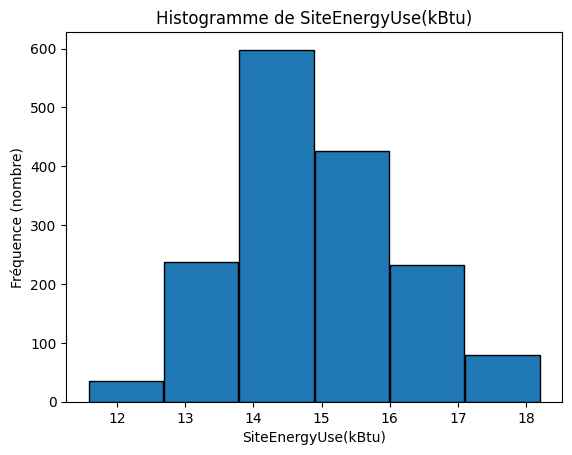

In [152]:
histo_interval_feat_continue(df_data, feature_target, nb_bins=7)

Nous affichons la répartition de la feature cible, en pourcentage

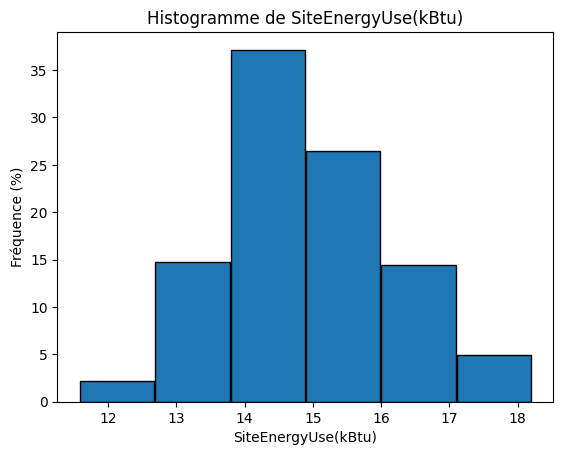

In [153]:
histo_interval_feat_continue(df_data, feature_target, nb_bins=7, normalisation=True)

___
**Bilan sur le jeu de données '2016_Building_Energy_Benchmarking_cleaned.csv'**: 
___
-   Le jeu de données contient **1_610 lignes et 18 colonnes**.
<br><br>
- Le dataset contient des informations sur les batiments : 
  - **administratif** : type de batiment, types de commerce installés 
  - **géographique** : nom et quartier du batiment
  - **temporelle** : âge des batiments
  - **structurelle** : superficie par commerce
  - **qualité énergétique** : ENERGY STAR Score
  - **consommation énergétique** : proportion des sources de consommation d'énergie (électricité, gaz naturel, vapeur)
  - **émissions** : quantité d'émission de gaz à effet de serre, ratio émission/superficie
<br><br>
- type de données :
  - **10 features de nombre décimaux numérique** : 
  - **6 features de texte**
  - 1 feature d'entier numérique
  - 1 feature de booléen
<br><br>
-   valeurs manquantes : 542 sur la feature **ENERGYSTARScore**
<br><br>
-   Aucun doublon
<br><br><br>

# <span style='background:blue'>Etape 2 : Feature Engineering</span>
___
## <span style='background:green'>1/ Renommage feature cible</span>

In [154]:
df_data = df_data.rename(columns={feature_target: "target"})
display(df_data.head())
display(df_data.shape)

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore_KNN,target,DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,60.0,15.79325,False,Compliant,5.52537,2.83,0.54606,0.27730,0.17664,89
1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,61.0,15.94230,False,Compliant,5.69326,2.86,0.38661,0.00000,0.61339,20
2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,43.0,18.10030,False,Compliant,7.64505,2.19,0.68231,0.29711,0.02058,47
3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1.0,Hotel,61320.0,56.0,15.73164,False,Compliant,5.66098,4.67,0.40752,0.32591,0.26657,90
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,1.0,Hotel,123445.0,75.0,16.46682,False,Compliant,6.22656,2.88,0.37880,0.00000,0.62120,36


(1610, 17)

## <span style='background:green'>2/ Séparation des features explicatives et de la feature cible</span>

Nous séparons le dataset en 2 jeux de données :
- X : les features explicatives
- y : la feature cible

In [155]:
# feature cible à séparer
feature_target_list = ["target", "TotalGHGEmissions"]

# X les feautres explicatives (sans les 2 features target) et y la target
X = df_data.drop(columns=feature_target_list)
y = df_data.target

Nous vérifions le dataframe des features explicatives.

In [156]:
display(X.head())
display(X.shape)

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore_KNN,DefaultData,ComplianceStatus,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,60.0,False,Compliant,2.83,0.54606,0.27730,0.17664,89
1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,61.0,False,Compliant,2.86,0.38661,0.00000,0.61339,20
2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,43.0,False,Compliant,2.19,0.68231,0.29711,0.02058,47
3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1.0,Hotel,61320.0,56.0,False,Compliant,4.67,0.40752,0.32591,0.26657,90
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,1.0,Hotel,123445.0,75.0,False,Compliant,2.88,0.37880,0.00000,0.62120,36


(1610, 15)

Nous vérifions le dataframe de la feature cible.

In [157]:
display(y.head())
display(y.shape)

0    15.79325
1    15.94230
2    18.10030
3    15.73164
4    16.46682
Name: target, dtype: float64

(1610,)

## <span style='background:green'>3/ Séparation des jeux d'entrainement et de test</span>

Nous séparons les 2 dataframes en 2 jeux : 
- un jeu d'entrainement (X et y) *contenant 75% des données*
- un jeu de test (X et y) *contenant 25% des données*

In [158]:
# Séparation des données en données d'entrainement et de test (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Affichage des dimensions des données
print(f"X_train fait {X_train.shape} et y_train fait {y_train.shape}.")
print(f"X_test fait {X_test.shape} et y_test fait {y_test.shape}.")

X_train fait (1207, 15) et y_train fait (1207,).
X_test fait (403, 15) et y_test fait (403,).


## <span style='background:green'>4/ Pré-traitement : encodage et standardisation</span>

Nous séparons les données numériques et les données catégorielles de notre dataset :

In [159]:
numerical_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(exclude=['int64','float64']).columns

**Pour les données catégorielles**, nous appliquons un prétraitement avec un transformeur comprennant :
1. Imputation
2. OneHotEncoding

In [160]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

**Pour les données numériques**, nous avons tout d'abord essayé un pré-traitement avec un transformeur comprennant :
1. Imputation
2. Scaler adapté à la distribution des données :
   - **StandardScaler** si distribution gaussienne (p-value de Shapiro-Wilk > 0.05)
   - **MinMaxScaler** si distribution non-gaussienne et absence d'outliers
   - **RobustScaler** si distribution non-gaussienne et présence d'outliers

In [161]:
# # Création du pipeline de prétraitement
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', ConditionalScaler(numerical_features))])

# # Création du preprocessor qui effectuera les transformations différenciées
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features), 
#         ('cat', categorical_transformer, categorical_features)])

# # Création du pipeline complet
# pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

Mais après l'application de ces scalers sur nos données d'entrainement et de test, les prédictions du modèle de machine learning SVR ne parvenait plus à converger pendant la recherche par GridSearchCV en moins de 30 minutes. Nous devions  arrêter le calcul pour pouvoir continuer à travailler.

Nous avons donc estimer que ce délai de calcul trop long n'est pas enviseageable pour répondre à la problématique de prédiction de consommation totale d'énergie. Nous avons donc décidé de ne pas standardiser les données numériques avec des scalers spécifiques mais de les standardiser avec un **StandardScaler** classique malgré que certaines features ne présentent pas une distribution gaussienne.

Ainsi :

**Pour les données numériques**, nous appliquons un pré-traitement avec un transformeur comprennant :
1. Imputation
2. StandardScaler (centrage + réduction)

In [162]:
# # Création du pipeline de prétraitement
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

Nous créons un transformeur général qui applique les 2 transformeurs précédents selon le type de données.

In [163]:
# Création du preprocessor qui effectuera les transformations différenciées
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Création du pipeline complet
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

Nous observons la distribution des données numériques avant le pré-traitement.

In [164]:
# isoler les features numériques
X_train_num = X_train.select_dtypes(include=['int64','float64'])

# describe
X_train_num.describe()

,NumberofBuildings,LargestPropertyUseTypeGFA,ENERGYSTARScore_KNN,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
count,1207.00000,1.20700e+03,1207.00000,1207.00000,1207.00000,1207.00000,1207.00000,1207.00000
mean,1.10108,8.58540e+04,63.39478,1.54914,0.70284,0.01980,0.27648,52.66280
std,1.22565,1.34133e+05,26.70654,2.11342,0.25558,0.08614,0.25664,32.50258
min,0.00000,6.45500e+03,1.00000,0.02000,0.00000,0.00000,0.00000,1.00000
25%,1.00000,2.56700e+04,46.00000,0.37000,0.49869,0.00000,0.00000,26.00000
50%,1.00000,4.33360e+04,69.00000,0.85000,0.70924,0.00000,0.24402,50.00000
75%,1.00000,8.87640e+04,86.00000,1.86000,0.99595,0.00000,0.48422,82.50000
max,27.00000,1.58596e+06,100.00000,25.71000,1.00000,0.70175,1.00000,116.00000


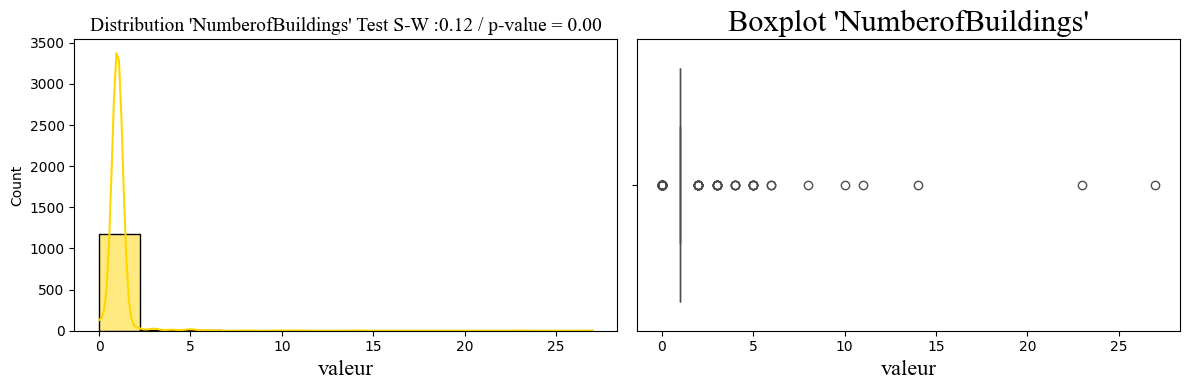

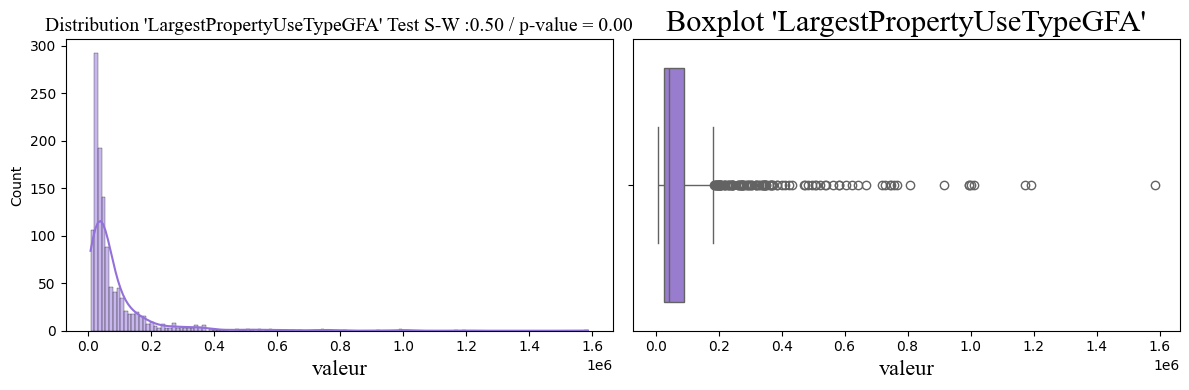

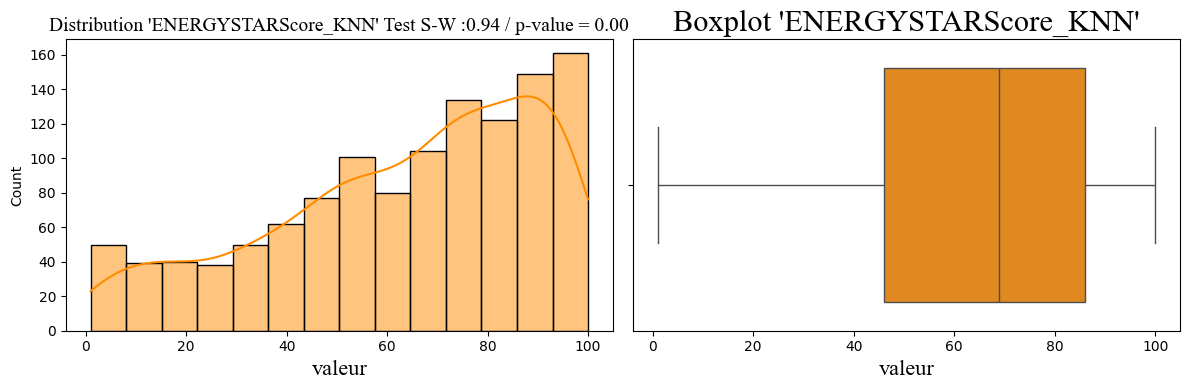

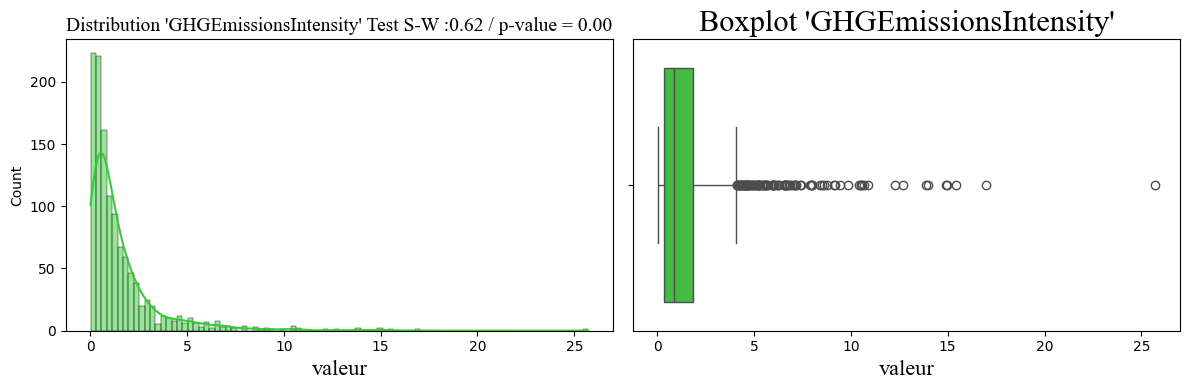

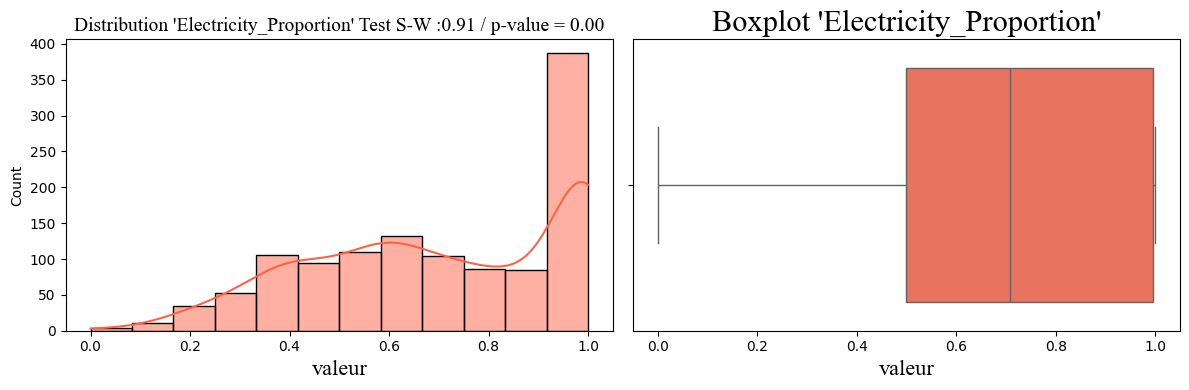

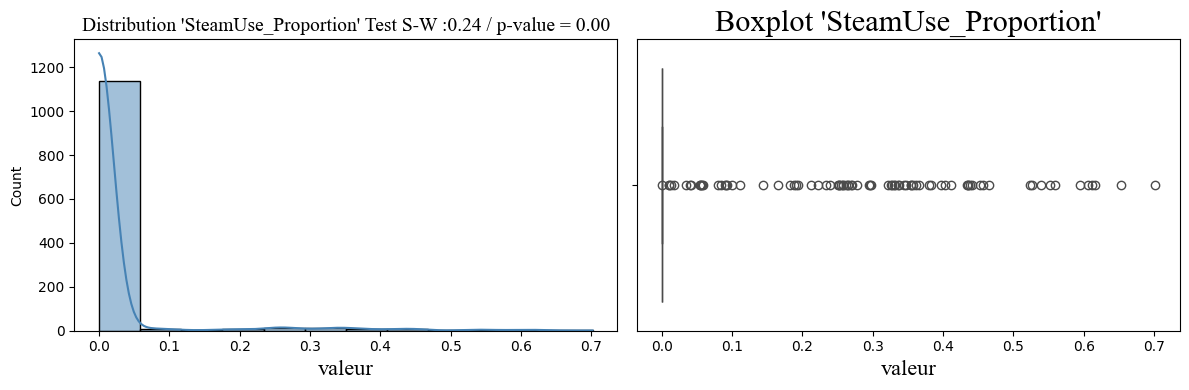

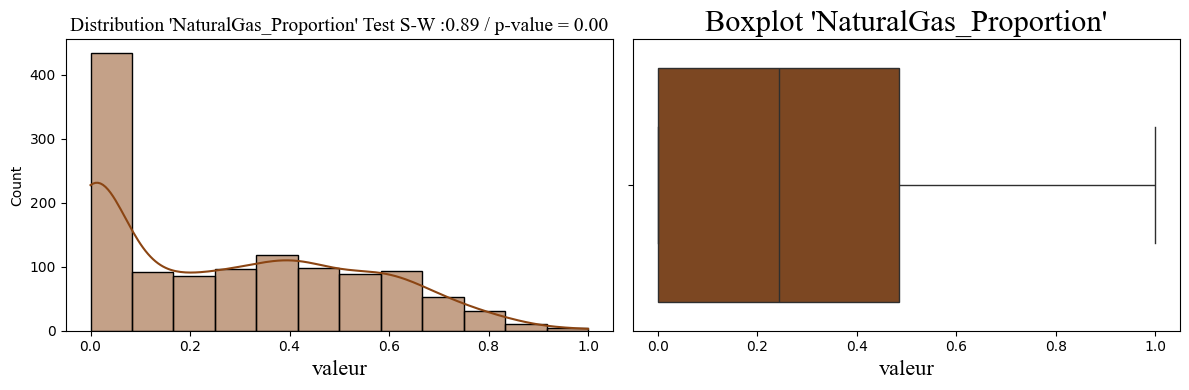

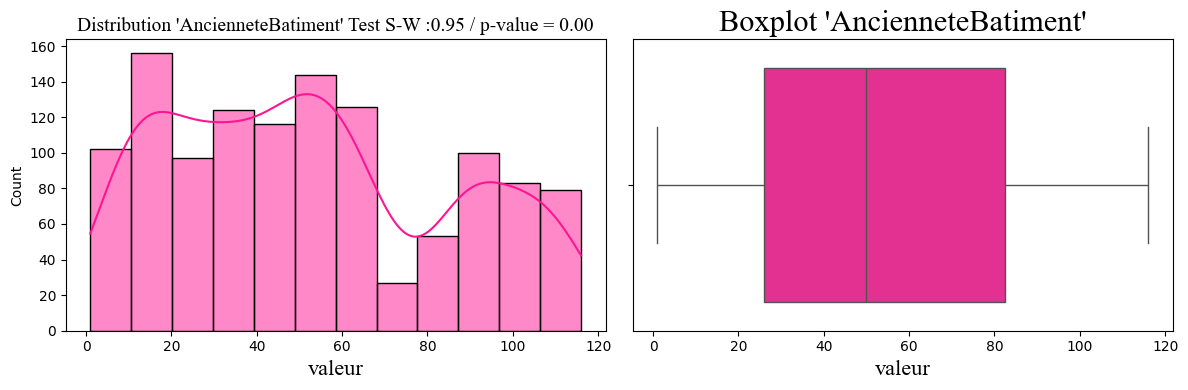

In [165]:
# POUR chaque feature numérique, afficher la distribution
for idx, col in enumerate(X_train_num): 
    plot_distribution(X_train_num, col, colors_list[idx], shapiro_wilk=True, unit="valeur")

Nous entrainons le transformeur général et l'appliquons sur le jeu d'entrainement. 

In [166]:
# Entrainement et transformation des données d'entrainement
X_train_transformed = pipeline.fit_transform(X_train)

Nous appliquons le transformeur général sur le jeu de test.

In [167]:
# transformation des données de test
X_test_transformed = pipeline.transform(X_test)

Les dimensions des jeux de données suite au pré-traitement sont les suivantes :

In [168]:
display(X_train_transformed.shape)

(1207, 1315)

In [169]:
display(X_test_transformed.shape)

(403, 1315)

Il y a 1300 features supplémentaires => Le OneHotEncoder a créé des nouvelles features pour chacunes des valeurs des features catégorielles. 

**C'est tout à fait normal.**

# <span style='background:blue'>Etape 3 : Modélisation</span>


## <span style='background:green'>1/ Modèle de régression naïf</span>

Nous créons un modèle de régression naïf qui prédit toujours la même valeur dans notre target. Ici nous choisissons la moyenne de la target.

In [170]:
# Création du modele de régression naïf
dummy_regr = DummyRegressor(strategy='mean')

# Entrainement du modèle de régression naïf
dummy_regr.fit(X_train_transformed, y_train)

DummyRegressor()

Nous réalisons les prédictions sur les jeux d'entrainement et de test (pré-traités).

In [171]:
y_pred_train = dummy_regr.predict(X_train_transformed)
y_pred_test = dummy_regr.predict(X_test_transformed)

Nous comptons le nombre de valeurs différentes dans la target ainsi prédite pour le jeu d'entrainement.

In [172]:
pd.Series(y_pred_test).value_counts()

14.89721    403
Name: count, dtype: int64

Le dummy regressor prédit toujours la moyenne de notre target. 

**Ici il prédit 403 fois la valeur 14.89721.**

Le jeu de test contient lui 403 valeurs différentes.

In [173]:
y_test.value_counts()

target
15.23764    1
12.81934    1
13.17449    1
12.50928    1
14.66533    1
           ..
14.04051    1
14.78889    1
15.73785    1
14.60568    1
15.54756    1
Name: count, Length: 403, dtype: int64

Voici les performances les plus basiques que nous obtenons avec le modèle de régression naïf :

In [174]:
# Dico vide pour stocker les résultats des grid search
resultats_eval_modele = {}

# Evaluation du modèle naïf
resultats_eval_modele['dummy'], dummy_regr = eval_modele(dummy_regr, X_train_transformed, X_test_transformed, y_train, y_test)

mse_train : 1.45
mse_test : 1.59
__________________________________________________
rmse_train : 1.2
rmse_test : 1.26
__________________________________________________
r²_train : 0.0
r²_test : -0.0
__________________________________________________
temps_fit (sec) : 0.0
temps_predict (sec) : 0.0
__________________________________________________


Ce sont les performances les plus basiques que nous devons battre avec nos modèles de régression.

## <span style='background:green'>2/ Modèles linéaires</span>

### <span style='background:yellow; color:black'>a/ ElasticNet</span>

Nous créons un modèle ElasticNet avec une recherche des meilleurs hyperparamètres par validation croisée.

In [175]:
# Dico vide pour stocker les résultats des grid search
resultats_grid_search = {}

# Définir les paramètres de la grille
param_grid_eNet = {
    'alpha': np.logspace(-4, 0, num=5),
    "l1_ratio": np.arange(0.0, 1.1, 0.1),
    'max_iter':[1_000, 2_000]}

# Effectuer la recherche sur la grid pour le modèle ElasticNet
grid_search_eNet, resultats_grid_search['eNet'] = grid_search_model(X_train_transformed, y_train, ElasticNet(), param_grid_eNet)

Fitting 5 folds for each of 110 candidates, totalling 550 fits



Best parameters: {'alpha': 0.01, 'l1_ratio': 0.0, 'max_iter': 2000}
Best score: 0.6741520933933268
Temps d'éxecution grid_search (seconds): 75.17 



Nous entrainons un modèle ElasticNet avec les meilleurs hyperparamètres trouvés avec GridSearchCV, puis nous l'évaluons sur le jeu d'entrainement et de test.

In [176]:
# Evaluation du modèle avec les meilleurs paramètres
resultats_eval_modele['eNet'], eNet_best_model = eval_modele(grid_search_eNet, X_train_transformed, X_test_transformed, y_train, y_test)

mse_train : 0.35
mse_test : 0.44
__________________________________________________
rmse_train : 0.59
rmse_test : 0.66
__________________________________________________
r²_train : 0.76
r²_test : 0.72
__________________________________________________
temps_fit (sec) : 3.74
temps_predict (sec) : 0.0
__________________________________________________


### <span style='background:yellow; color:black'>b/ SVR</span>

Nous créons un modèle SVR avec une recherche des meilleurs hyperparamètres par validation croisée.

In [177]:
# Définir les paramètres de la grille
param_grid_svr = {
    'C': np.logspace(-3, 2, num=6),
    'epsilon': np.logspace(-2, 1, num=4),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# Effectuer la recherche sur grid pour le modèle SVR
grid_search_svr, resultats_grid_search['svr'] = grid_search_model(X_train_transformed, y_train, SVR(), param_grid_svr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits



Best parameters: {'C': 100.0, 'epsilon': 0.01, 'kernel': 'rbf'}
Best score: 0.8776404806032753
Temps d'éxecution grid_search (seconds): 4.89 



Nous entrainons un modèle SVR avec les meilleurs hyperparamètres trouvés avec GridSearchCV, puis nous l'évaluons sur le jeu de d'entrainement et de test.

In [178]:
# Evaluation du modèle avec les meilleurs paramètres
resultats_eval_modele['svr'], svr_best_model = eval_modele(grid_search_svr, X_train_transformed, X_test_transformed, y_train, y_test)

mse_train : 0.0
mse_test : 0.15
__________________________________________________
rmse_train : 0.0
rmse_test : 0.39
__________________________________________________
r²_train : 1.0
r²_test : 0.91
__________________________________________________
temps_fit (sec) : 0.11
temps_predict (sec) : 0.06
__________________________________________________


## <span style='background:green'>3/ Modèles non-linéaires</span>

### <span style='background:yellow; color:black'>a/ RandomForest</span>

In [179]:
# Définir les paramètres de la grille
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Effectuer la recherche sur la grid pour le modèle RandomForest
grid_search_rf, resultats_grid_search['rf'] = grid_search_model(X_train_transformed, y_train, RandomForestRegressor(), param_grid_rf)

Fitting 5 folds for each of 108 candidates, totalling 540 fits



Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best score: 0.9062546045056197
Temps d'éxecution grid_search (seconds): 526.24 



Nous entrainons un modèle RandomForest avec les meilleurs hyperparamètres trouvés avec GridSearchCV, puis nous l'évaluons sur le jeu de d'entrainement et de test.

In [180]:
# Evaluation du modèle avec les meilleurs paramètres
resultats_eval_modele['rf'], rf_best_model = eval_modele(grid_search_rf, X_train_transformed, X_test_transformed, y_train, y_test)

mse_train : 0.03
mse_test : 0.13
__________________________________________________
rmse_train : 0.17
rmse_test : 0.36
__________________________________________________
r²_train : 0.98
r²_test : 0.92
__________________________________________________
temps_fit (sec) : 12.43
temps_predict (sec) : 0.12
__________________________________________________


### <span style='background:yellow; color:black'>b/ GradientBoosting</span>

In [181]:
# Définir les paramètres de la grille
param_grid_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 8],
    'subsample': [0.5, 0.7, 1.0]}

# Effectuer la recherche sur la grid pour le modèle GradientBoosting
grid_search_gb, resultats_grid_search['gb'] = grid_search_model(X_train_transformed, y_train, GradientBoostingRegressor(), param_grid_gb)

Fitting 5 folds for each of 81 candidates, totalling 405 fits



Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}
Best score: 0.9419496515538309
Temps d'éxecution grid_search (seconds): 190.04 



Nous entrainons un modèle GradientBoosting avec les meilleurs hyperparamètres trouvés avec GridSearchCV, puis nous l'évaluons sur le jeu de d'entrainement et de test.

In [182]:
# Evaluation du modèle avec les meilleurs paramètres
resultats_eval_modele['gb'], gb_best_model = eval_modele(grid_search_gb, X_train_transformed, X_test_transformed, y_train, y_test)

# list des résultats des différents datasets
resultats_dataset_diff = {}
resultats_dataset_diff['avec_ENERGYSTAR_imputé'] = resultats_eval_modele['gb']

mse_train : 0.01
mse_test : 0.09
__________________________________________________
rmse_train : 0.1
rmse_test : 0.3
__________________________________________________
r²_train : 0.99
r²_test : 0.95
__________________________________________________
temps_fit (sec) : 2.1
temps_predict (sec) : 0.02
__________________________________________________


## <span style='background:green'>4/ Choix du modèle le plus adapté</span>

Nous rassemblons les résultats des gridsearch des différents modèles dans un dataframe.

In [183]:
df_resultats_grid_search = pd.DataFrame(resultats_grid_search).T
display(df_resultats_grid_search)

,best_params,best_score,grid_search_time
eNet,"{'alpha': 0.01, 'l1_ratio': 0.0, 'max_iter': 2...",0.67415,75.17
svr,"{'C': 100.0, 'epsilon': 0.01, 'kernel': 'rbf'}",0.87764,4.89
rf,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",0.90625,526.24
gb,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.94195,190.04


Nous rassemblons les résultats des évaluations des performances des différents modèles dans un dataframe.

In [184]:
df_resultats_eval_modele = pd.DataFrame(resultats_eval_modele).T
display(df_resultats_eval_modele)

,mse_train,mse_test,rmse_train,rmse_test,r²_train,r²_test,temps_fit (sec),temps_predict (sec)
dummy,1.45,1.59,1.20,1.26,0.00,-0.00,0.00,0.00
eNet,0.35,0.44,0.59,0.66,0.76,0.72,3.74,0.00
svr,0.00,0.15,0.00,0.39,1.00,0.91,0.11,0.06
rf,0.03,0.13,0.17,0.36,0.98,0.92,12.43,0.12
gb,0.01,0.09,0.10,0.30,0.99,0.95,2.10,0.02


Nous comparons les performances des 4 modèles de régression testés.

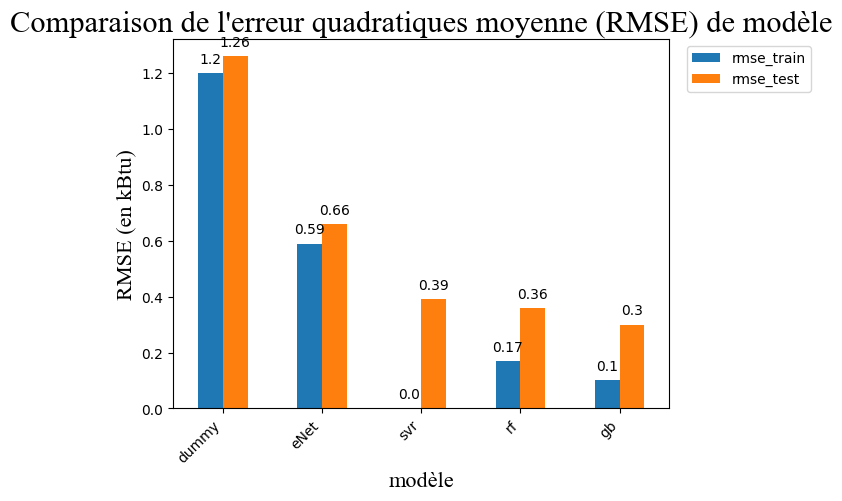

In [185]:
# Comparaison des RMSE des différents modèles
compare_perf(df_resultats_eval_modele, "rmse", "modèle", font_title, font_axe, features=['rmse_train', 'rmse_test'])

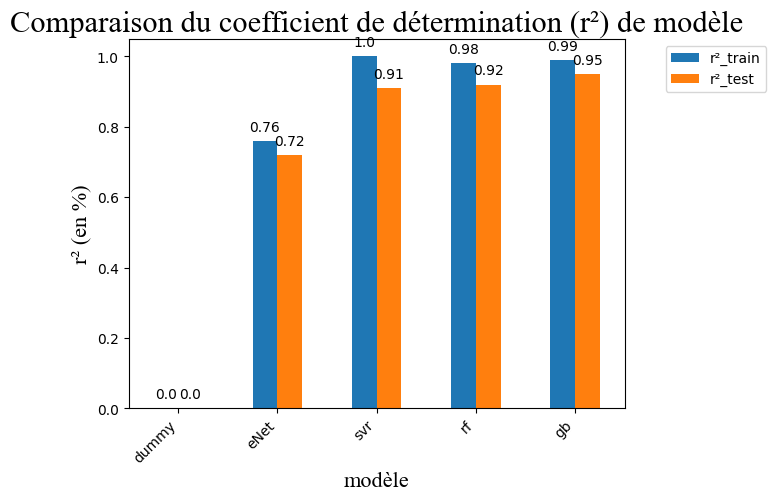

In [186]:
# Comparaison des r² des différents modèles
compare_perf(df_resultats_eval_modele, "r²", "modèle", font_title, font_axe, features=['r²_train', 'r²_test'])

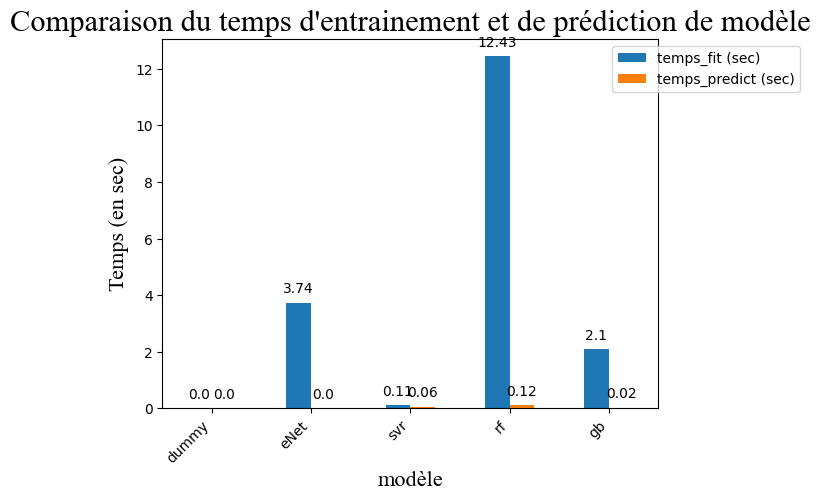

In [187]:
# Comparaison des temps de calcul des différents modèles
compare_perf(df_resultats_eval_modele, "temps", "modèle", font_title, font_axe, features=['temps_fit (sec)', 'temps_predict (sec)'])

Nous sélectionnons le modèle qui a les meilleures performances sur le jeu de test. A savoir le modèle **GradientBoosting** qui présente la RMSE la plus faible et le R² le plus élevé tout en présentant des temps de calcul raisonnable.

# <span style='background:blue'>Etape 4 : Feature importance</span>

## <span style='background:green'>1/ Feature importance globale</span>

La **feature importance globale** permet d'étudier l'importance de chaque feature dans la prédiction de la feature cible. 

Nous calculons les valeurs de Shapley grâce à la méthode TreeExplainer de la librairie Shap. 

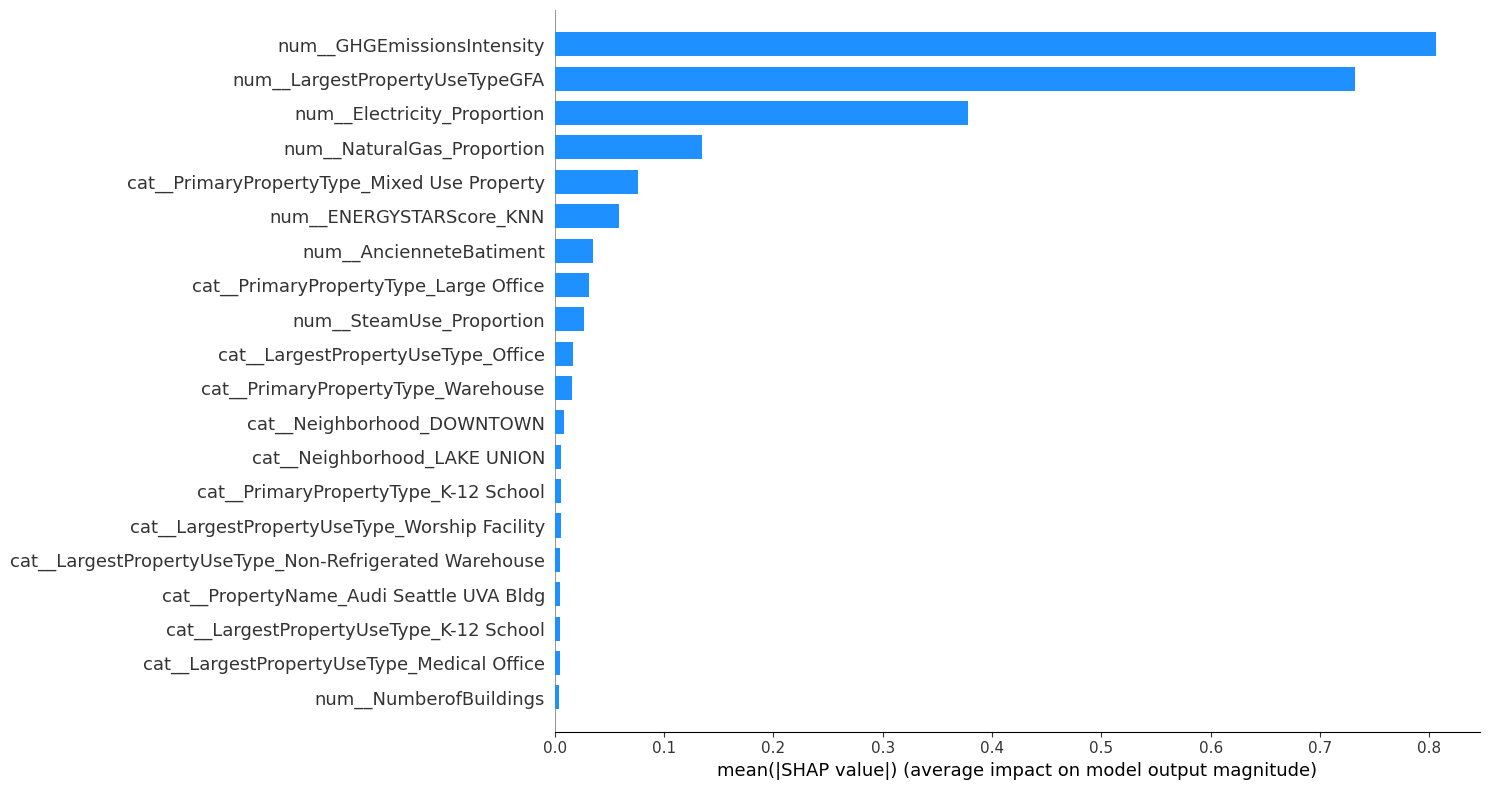

In [188]:
# Obtenir les noms des caractéristiques après la transformation
noms_des_features = preprocessor.get_feature_names_out()

# Convertir csr_matrix en tableau numpy
X_train_transformed_array = X_train_transformed.toarray()   # type: ignore
X_test_transformed_array = X_test_transformed.toarray() # type: ignore

# Initialiser l'explainer (avec les données d'entrainement)
explainer = shap.TreeExplainer(gb_best_model, X_train_transformed_array)

# Calculer les valeurs SHAP (avec les données de test)
shap_values_temp = explainer.shap_values(X_test_transformed_array)

# Afficher le plot de résumé SHAP
shap.summary_plot(shap_values_temp,
                feature_names=noms_des_features,
                plot_type="bar",
                color="dodgerblue", 
                plot_size=(15, 8))

Ce graphique est intérressant mais nous ne voyons pas si les features les plus importantes ont une corrélation positive ou négative sur la target.

Nous allons afficher un graphique plus intérressant en affichant les valeurs de Shapley selon leur corrélations (positive ou négative) avec la target:
- Les features affichées en **rouge** sont celles qui ont une **corrélation positive** avec la target. 
- Les features affichées en bleu sont celles qui ont une corrélation négative avec la target.

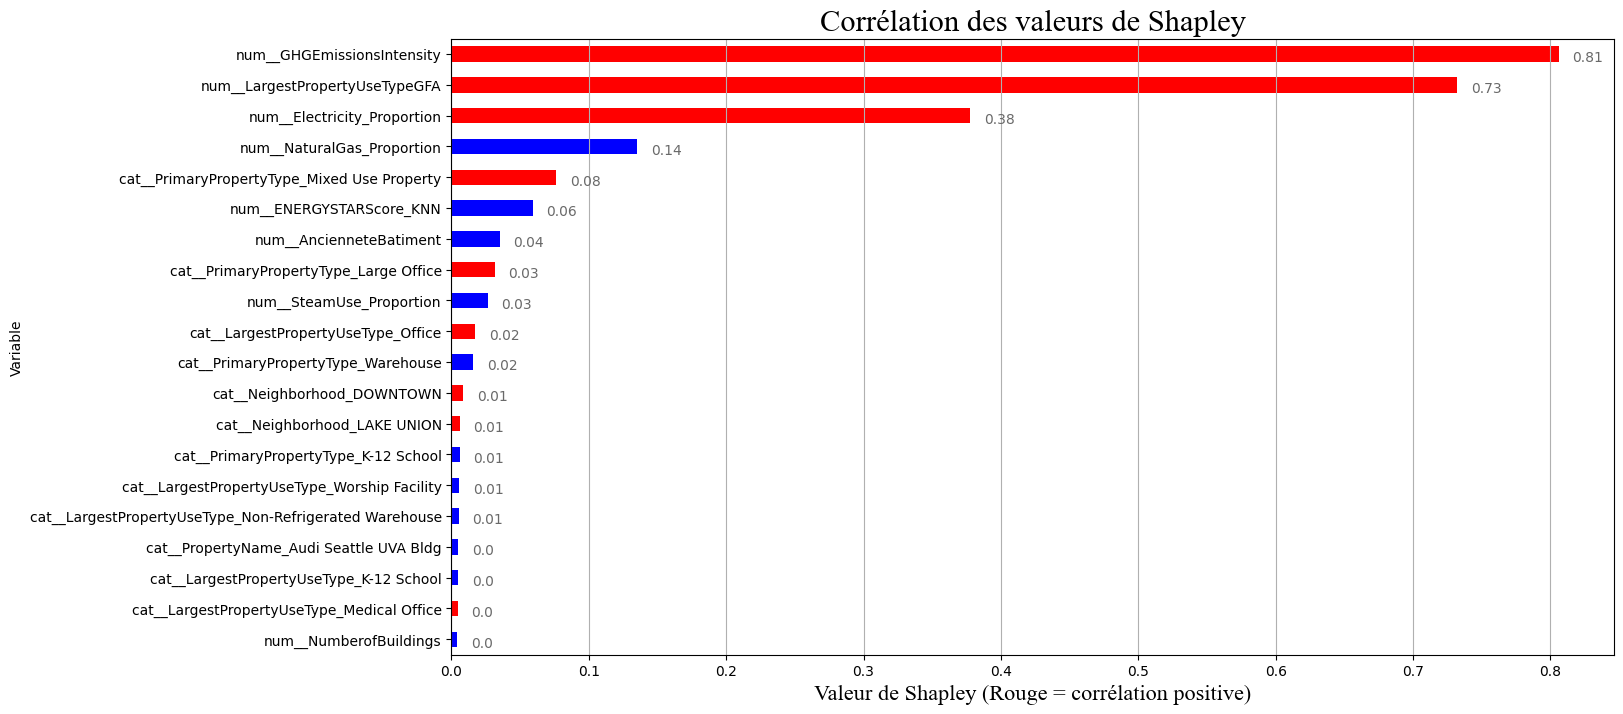

In [189]:
# Transformer les données de test en DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed_array, columns=noms_des_features)

# Afficher les valeurs SHAP selon leur correlation avec la variable cible
shap_plot_avec_couleur(shap_values_temp, X_test_transformed_df)

# list des résultats des valeurs de Shapley pour chaque dataset
shap_values = {}

# Sauvegarde des données de test transformées et des valeurs de Shapley
shap_values["avec_ENERGYSTAR_imputé"] = {}
shap_values["avec_ENERGYSTAR_imputé"]["X_test_transformed_df"] = X_test_transformed_df
shap_values["avec_ENERGYSTAR_imputé"]["shap_values"] = shap_values_temp

Voici encore une autre représentation des valeurs de Shapley. Cette fois-ci, tous les batiments sont affichés sur un même graphique. Ces derniers sont colorés selon la valeur de la feature et positionnées sur l'axe des X selon leur valeur de Shapley.

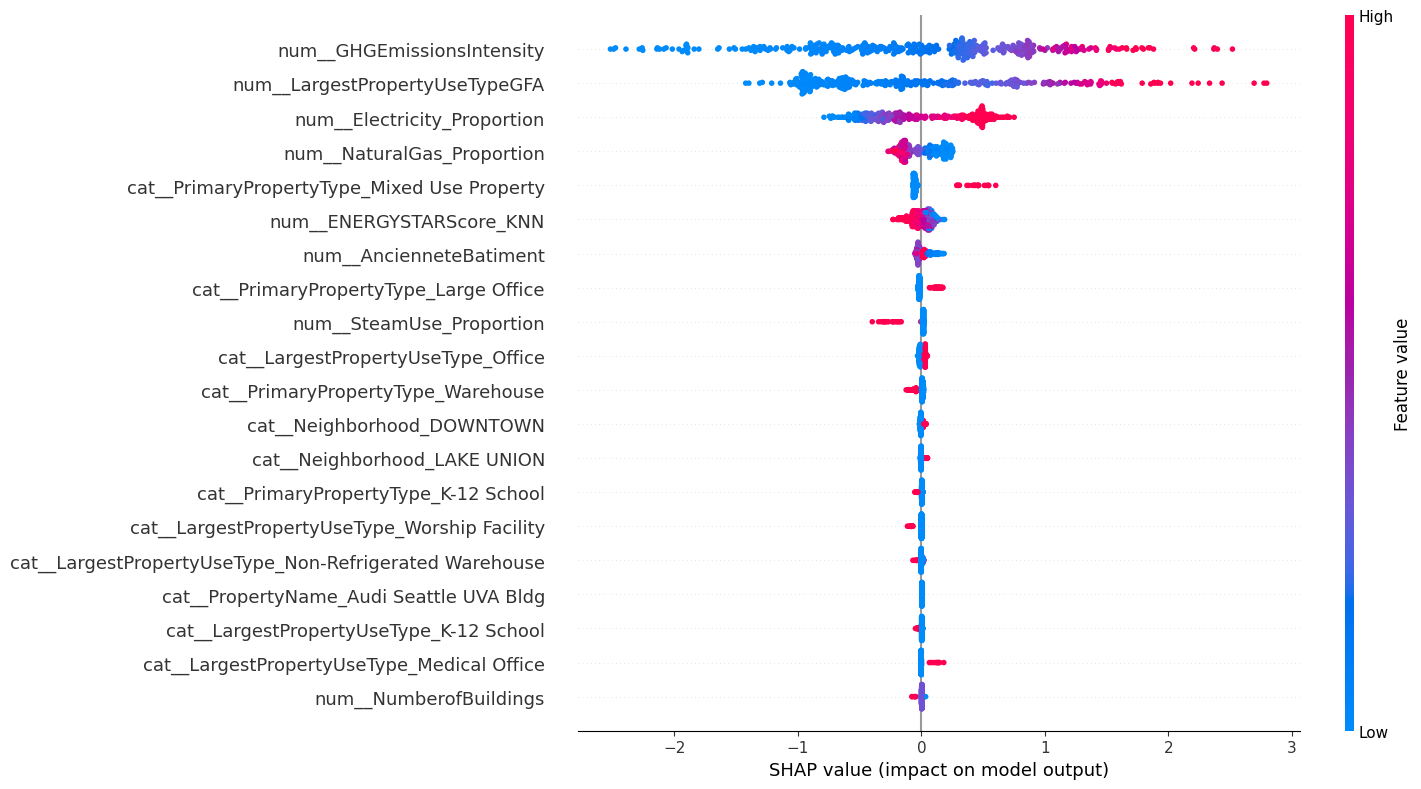

In [190]:
shap.summary_plot(shap_values_temp, X_test_transformed_df, plot_size=(15, 8))

Nous pouvons décrire le modèle de **manière globale**. Une valeur de consommation annuelle d'énergie élevée est associée à (valeur de Shapley > 0.05) :
- Un ratio d'émission de CO2 / surface élevé
- Une surface de type d'usage principal élevée
- Une proportion d'énergie provenant de l'électricité élevée
- Une proportion d'énergie provenant du gaz naturel faible
- D'une utilisation mixte du batiment
- Un score ENERGY STAR faible

## <span style='background:green'>2/ Feature importance locale</span>

La **feature importance locale** permet d'étudier l'importance des features pour une prédiction spécifique.

Nous utilisons la méthode "permutation_importance" de sklearn. 

In [191]:
# dico vide pour stocker les résultats
importance_locale_df = {}

# Calcul de l'importance des caractéristiques par permutation
importance_locale_df['avec_ENERGYSTAR_imputé'] = feature_importance_locale(gb_best_model, X_test_transformed_df, y_test, n_repeats=10, random_state=42, n_jobs=-1)

display(importance_locale_df['avec_ENERGYSTAR_imputé'])

,feature,importance
3,num__GHGEmissionsIntensity,1.24987
1,num__LargestPropertyUseTypeGFA,0.97696
4,num__Electricity_Proportion,0.22468
6,num__NaturalGas_Proportion,0.04407
21,cat__PrimaryPropertyType_Mixed Use Property,0.02047
2,num__ENERGYSTARScore_KNN,0.00864
18,cat__PrimaryPropertyType_Large Office,0.00259
7,num__AncienneteBatiment,0.00240
5,num__SteamUse_Proportion,0.00207
1279,cat__LargestPropertyUseType_Office,0.00096


Nous pouvons décrire le modèle de **manière locale**. Les features dont les permutations sont les plus importantes sont (importance > 0.05) : 
- Le ratio d'émission de CO2 / surface
- La surface de type d'usage principal
- La proportion d'énergie provenant de l'électricité

=> Les features qui sont présentent de l'importance en globale et en locale sont :
- **Le ratio d'émission de CO2 / surface**
- **La surface de type d'usage principal**
- **La proportion d'énergie provenant de l'électricité**

# <span style='background:blue'>Etape 5 : Etude de l'apport du score ENERGY STAR</span>

## <span style='background:green'>1/ Performance du modèle SANS le score ENERGY STAR imputé</span>

Les résultats que nous avons obtenus jusqu'à présent sont ceux d'un modèle qui a été entrainé avec le score ENERGY STAR imputé. Nous allons maintenant entrainer un modèle sans le score ENERGY STAR imputé pour voir si ce dernier apporte une amélioration des performances.

### <span style='background:yellow; color:black'>a/ Suppression feature</span>

Nous enlevons la feature **ENERGY STAR Score** imputé du jeu de données.

In [192]:
# Suppression de la feature ENERGYSTARScore
X_sans_STAR = X.drop(columns='ENERGYSTARScore_KNN')

# Affichage
display(X_sans_STAR.head())
display(X_sans_STAR.shape)

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,False,Compliant,2.83,0.54606,0.27730,0.17664,89
1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,False,Compliant,2.86,0.38661,0.00000,0.61339,20
2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,False,Compliant,2.19,0.68231,0.29711,0.02058,47
3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1.0,Hotel,61320.0,False,Compliant,4.67,0.40752,0.32591,0.26657,90
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,1.0,Hotel,123445.0,False,Compliant,2.88,0.37880,0.00000,0.62120,36


(1610, 14)

### <span style='background:yellow; color:black'>b/ Séparation des jeux d'entrainement et de test</span>

In [193]:
# Séparation des données en données d'entrainement et de test (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(X_sans_STAR, y, test_size=0.25, random_state=42)

# Affichage des dimensions des données
print(f"X_train fait {X_train.shape} et y_train fait {y_train.shape}.")

print(f"X_test fait {X_test.shape} et y_test fait {y_test.shape}.")

X_train fait (1207, 14) et y_train fait (1207,).
X_test fait (403, 14) et y_test fait (403,).


### <span style='background:yellow; color:black'>c/ Pré-traitement : encodage et standardisation</span>

In [194]:
# MAJ des features numériques
numerical_features = X_sans_STAR.select_dtypes(include=['int64','float64']).columns

# MAJ du preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features), 
    ('cat', categorical_transformer, categorical_features)])

# Prétraitement des données d'entrainement et de test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### <span style='background:yellow; color:black'>d/ Modélisation</span>

Nous évaluons le modèle qui a présenté les meilleures performances sur le jeu de test.

In [195]:
# Evaluation du modèle avec les meilleurs paramètres
resultats_dataset_diff['sans_ENERGYSTAR_imputé'], gb_best_model = eval_modele(grid_search_gb, X_train_transformed, X_test_transformed, y_train, y_test)

mse_train : 0.01
mse_test : 0.09
__________________________________________________
rmse_train : 0.1
rmse_test : 0.3
__________________________________________________
r²_train : 0.99
r²_test : 0.94
__________________________________________________
temps_fit (sec) : 2.22
temps_predict (sec) : 0.02
__________________________________________________


### <span style='background:yellow; color:black'>e/ Feature importance</span>

#### Globale

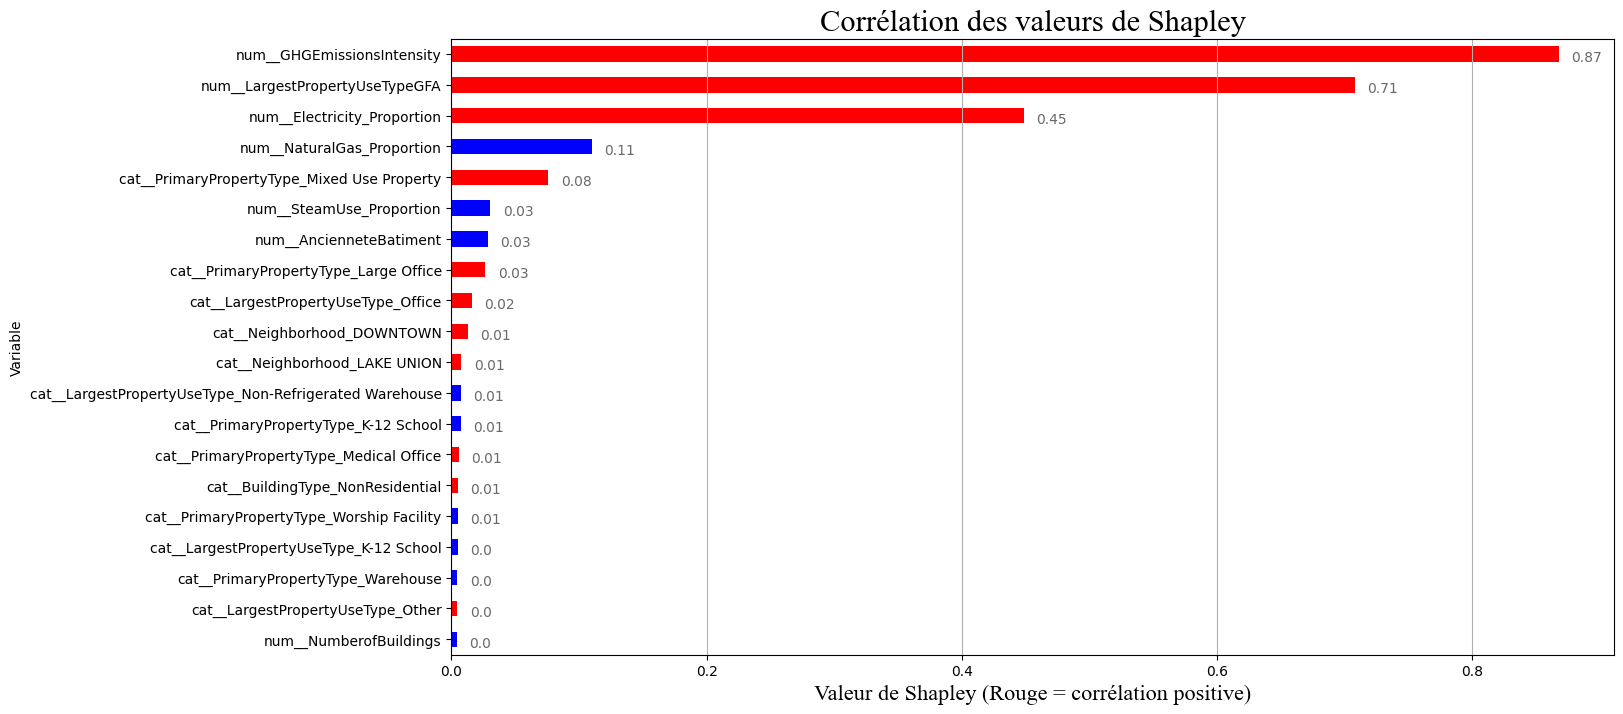

In [196]:
# Calcul des valeurs de Shapley des features 
X_test_transformed_df, shap_values_temp = feature_importance_globale(preprocessor, X_train_transformed, X_test_transformed, model=gb_best_model)

# Sauvegarde des données de test transformées et des valeurs de Shapley
shap_values["sans_ENERGYSTAR_imputé"] = {}
shap_values["sans_ENERGYSTAR_imputé"]["X_test_transformed_df"] = X_test_transformed_df
shap_values["sans_ENERGYSTAR_imputé"]["shap_values"] = shap_values_temp

#### Locale

In [197]:
# Calcul de l'importance des caractéristiques par permutation
importance_locale_df['sans_ENERGYSTAR_imputé'] = feature_importance_locale(gb_best_model, X_test_transformed_df, y_test, n_repeats=10, random_state=42, n_jobs=-1)

display(importance_locale_df['sans_ENERGYSTAR_imputé'])

,feature,importance
2,num__GHGEmissionsIntensity,1.41537
1,num__LargestPropertyUseTypeGFA,0.93669
3,num__Electricity_Proportion,0.30126
5,num__NaturalGas_Proportion,0.03050
20,cat__PrimaryPropertyType_Mixed Use Property,0.01997
4,num__SteamUse_Proportion,0.00396
6,num__AncienneteBatiment,0.00264
17,cat__PrimaryPropertyType_Large Office,0.00208
1243,cat__Neighborhood_DOWNTOWN,0.00128
1278,cat__LargestPropertyUseType_Office,0.00099


## <span style='background:green'>2/ Performance du modèle AVEC le score ENERGY STAR incomplet</span>

Les résultats que nous avons obtenus jusqu'à présent sont ceux d'un modèle qui a été entrainé avec ou sans le score ENERGY STAR imputé. Nous allons faire la même chose mais cette fois-ci avec le score ENERGY STAR incomplet.

Commençons par le dataset avec le score ENERGY STAR incomplet.

### <span style='background:yellow; color:black'>a/ Ajout feature</span>

Nous ajoutons la feature **ENERGY STAR Score** incomplet du jeu de données.

In [198]:
# Ré-intégrant la feature ENERGYSTARScore
X_STAR_Nan = X_sans_STAR.assign(ENERGYSTARScore=ENERGYSTARScore)

# Affichage
display(X_STAR_Nan.head())
display(X_STAR_Nan.shape)

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment,ENERGYSTARScore
0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,False,Compliant,2.83,0.54606,0.27730,0.17664,89,60.0
1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,False,Compliant,2.86,0.38661,0.00000,0.61339,20,61.0
2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,False,Compliant,2.19,0.68231,0.29711,0.02058,47,43.0
3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1.0,Hotel,61320.0,False,Compliant,4.67,0.40752,0.32591,0.26657,90,56.0
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,1.0,Hotel,123445.0,False,Compliant,2.88,0.37880,0.00000,0.62120,36,75.0


(1610, 15)

Nous vérifions que la feature a bien été ajoutée (avec ses valeurs manquantes).

In [199]:
# detection de tous les Nan
X_STAR_Nan.isna().sum().sum()

542

Nous filtrons le jeu de données pour ne garder que les lignes qui ont une valeur pour la feature **ENERGY STAR Score**.

In [200]:
# Filtrer les lignes avec des valeurs NaN
X_STAR_clean = X_STAR_Nan.dropna(subset=['ENERGYSTARScore'])

# Affichage
display(X_STAR_clean.head())
display(X_STAR_clean.shape)

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment,ENERGYSTARScore
0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,False,Compliant,2.83,0.54606,0.27730,0.17664,89,60.0
1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,False,Compliant,2.86,0.38661,0.00000,0.61339,20,61.0
2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,False,Compliant,2.19,0.68231,0.29711,0.02058,47,43.0
3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1.0,Hotel,61320.0,False,Compliant,4.67,0.40752,0.32591,0.26657,90,56.0
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,1.0,Hotel,123445.0,False,Compliant,2.88,0.37880,0.00000,0.62120,36,75.0


(1068, 15)

Nous vérifions que le jeu de données filtré ne contient plus de valeurs manquantes.

In [201]:
# detection de tous les Nan
X_STAR_clean.isna().sum().sum()

0

Nous filtrons y sur les mêmes lignes.

In [202]:
# Filtrer y sur les mêmes lignes
y_clean = y[X_STAR_clean.index]

# Affichage
display(y_clean.head())
display(y_clean.shape)

0    15.79325
1    15.94230
2    18.10030
3    15.73164
4    16.46682
Name: target, dtype: float64

(1068,)

Nous réalisons un reset des index pour X et y avec leur nouveau nombre de lignes.

In [203]:
# Reset index
X_STAR_clean = X_STAR_clean.reset_index(drop=True)
y_clean = y_clean.reset_index(drop=True)

# Affichage
display(X_STAR_clean) 
display(y_clean) 

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment,ENERGYSTARScore
0,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1.0,Hotel,88434.0,False,Compliant,2.83,0.54606,0.27730,0.17664,89,60.0
1,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1.0,Hotel,83880.0,False,Compliant,2.86,0.38661,0.00000,0.61339,20,61.0
2,NonResidential,Hotel,5673-The Westin Seattle,DOWNTOWN,1.0,Hotel,756493.0,False,Compliant,2.19,0.68231,0.29711,0.02058,47,43.0
3,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1.0,Hotel,61320.0,False,Compliant,4.67,0.40752,0.32591,0.26657,90,56.0
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),DOWNTOWN,1.0,Hotel,123445.0,False,Compliant,2.88,0.37880,0.00000,0.62120,36,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,NonResidential,Small- and Mid-Sized Office,Airport - Main Terminal,GREATER DUWAMISH,1.0,Office,24990.0,False,Compliant,5.39,0.49021,0.00000,0.50979,87,9.0
1064,NonResidential,K-12 School,Hamlin Robinson School,GREATER DUWAMISH,1.0,K-12 School,45728.0,False,Compliant,0.21,1.00000,0.00000,0.00000,1,77.0
1065,Nonresidential COS,Office,Central West HQ / Brown Bear,MAGNOLIA / QUEEN ANNE,1.0,Office,13661.0,True,Error - Correct Default Data,0.26,1.00000,0.00000,0.00000,64,75.0
1066,Nonresidential COS,Office,Genesee/SC SE HQ,SOUTHEAST,1.0,Office,15398.0,True,Error - Correct Default Data,0.51,0.71565,0.00000,0.28435,56,93.0


0       15.79325
1       15.94230
2       18.10030
3       15.73164
4       16.46682
          ...   
1063    15.30180
1064    14.09766
1065    13.12769
1066    12.86827
1067    13.65269
Name: target, Length: 1068, dtype: float64

### <span style='background:yellow; color:black'>b/ Séparation des jeux d'entrainement et de test</span>

In [204]:
# Séparation des données en données d'entrainement et de test (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(X_STAR_clean, y_clean, test_size=0.25, random_state=42)

# Affichage des dimensions des données
print(f"X_train fait {X_train.shape} et y_train fait {y_train.shape}.")

print(f"X_test fait {X_test.shape} et y_test fait {y_test.shape}.")

X_train fait (801, 15) et y_train fait (801,).
X_test fait (267, 15) et y_test fait (267,).


### <span style='background:yellow; color:black'>c/ Pré-traitement : encodage et standardisation</span>

In [205]:
# MAJ des features numériques
numerical_features = X_STAR_clean.select_dtypes(include=['int64','float64']).columns

# MAJ du preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features), 
    ('cat', categorical_transformer, categorical_features)])

# Prétraitement des données d'entrainement et de test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### <span style='background:yellow; color:black'>d/ Modélisation</span>

Nous évaluons le modèle qui a présenté les meilleures performances sur le jeu de test.

In [206]:
# Evaluation du modèle avec les meilleurs paramètres
resultats_dataset_diff['avec_ENERGYSTAR_incomplet'], gb_best_model = eval_modele(grid_search_gb, X_train_transformed, X_test_transformed, y_train, y_test)

mse_train : 0.01
mse_test : 0.06
__________________________________________________
rmse_train : 0.1
rmse_test : 0.24
__________________________________________________
r²_train : 1.0
r²_test : 0.95
__________________________________________________
temps_fit (sec) : 1.65
temps_predict (sec) : 0.01
__________________________________________________


### <span style='background:yellow; color:black'>e/ Feature importance</span>

#### Globale

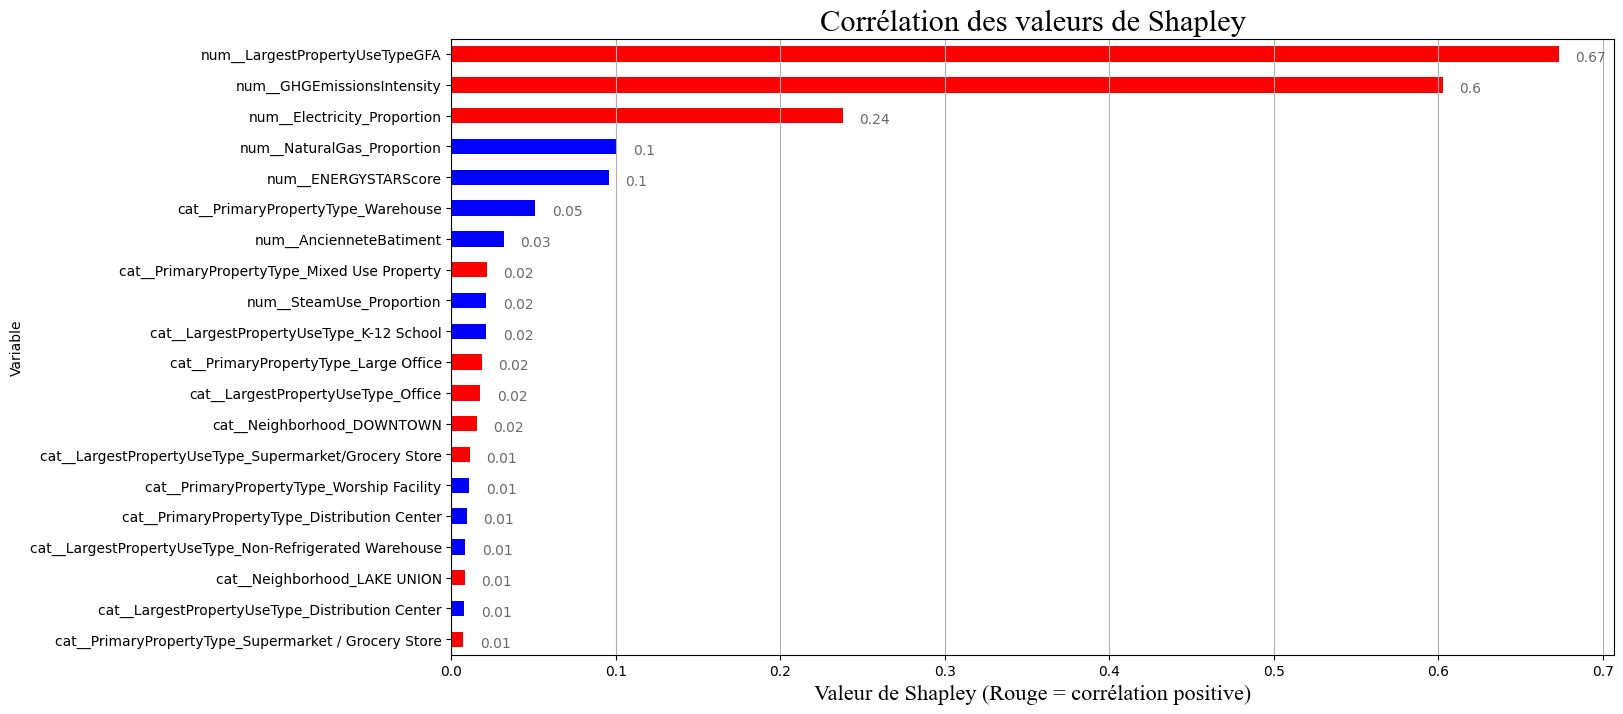

In [207]:
# Calcul des valeurs de Shapley des features 
X_test_transformed_df, shap_values_temp = feature_importance_globale(preprocessor, X_train_transformed, X_test_transformed, model=gb_best_model)

# Sauvegarde des données de test transformées et des valeurs de Shapley
shap_values["avec_ENERGYSTAR_incomplet"] = {}
shap_values["avec_ENERGYSTAR_incomplet"]["X_test_transformed_df"] = X_test_transformed_df
shap_values["avec_ENERGYSTAR_incomplet"]["shap_values"] = shap_values_temp

#### Locale

In [208]:
# Calcul de l'importance des caractéristiques par permutation
importance_locale_df['avec_ENERGYSTAR_incomplet'] = feature_importance_locale(gb_best_model, X_test_transformed_df, y_test, n_repeats=10, random_state=42, n_jobs=-1)

display(importance_locale_df['avec_ENERGYSTAR_incomplet'])

,feature,importance
1,num__LargestPropertyUseTypeGFA,1.04245
2,num__GHGEmissionsIntensity,0.95899
3,num__Electricity_Proportion,0.12122
7,num__ENERGYSTARScore,0.02876
5,num__NaturalGas_Proportion,0.02610
28,cat__PrimaryPropertyType_Warehouse,0.00830
19,cat__PrimaryPropertyType_Mixed Use Property,0.00562
6,num__AncienneteBatiment,0.00355
856,cat__LargestPropertyUseType_K-12 School,0.00301
867,cat__LargestPropertyUseType_Supermarket/Grocer...,0.00197


## <span style='background:green'>3/ Performance du modèle SANS le score ENERGY STAR incomplet</span>

Maintenant nous réalisons le même travail mais cette fois-ci sans le score ENERGY STAR incomplet.

### <span style='background:yellow; color:black'>a/ Suppression feature</span>

Nous enlevons la feature **ENERGY STAR Score** incomplet du jeu de données.

In [209]:
# Suppression de la feature ENERGYSTARScore
X_sans_STAR_clean = X_STAR_clean.drop(columns='ENERGYSTARScore')

# Affichage
display(X_sans_STAR_clean.tail())
display(X_sans_STAR_clean.shape)

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,GHGEmissionsIntensity,Electricity_Proportion,SteamUse_Proportion,NaturalGas_Proportion,AncienneteBatiment
1063,NonResidential,Small- and Mid-Sized Office,Airport - Main Terminal,GREATER DUWAMISH,1.0,Office,24990.0,False,Compliant,5.39,0.49021,0.0,0.50979,87
1064,NonResidential,K-12 School,Hamlin Robinson School,GREATER DUWAMISH,1.0,K-12 School,45728.0,False,Compliant,0.21,1.00000,0.0,0.00000,1
1065,Nonresidential COS,Office,Central West HQ / Brown Bear,MAGNOLIA / QUEEN ANNE,1.0,Office,13661.0,True,Error - Correct Default Data,0.26,1.00000,0.0,0.00000,64
1066,Nonresidential COS,Office,Genesee/SC SE HQ,SOUTHEAST,1.0,Office,15398.0,True,Error - Correct Default Data,0.51,0.71565,0.0,0.28435,56
1067,Nonresidential COS,Office,Horticulture building,GREATER DUWAMISH,1.0,Office,12294.0,True,Error - Correct Default Data,1.70,0.61697,0.0,0.38303,26


(1068, 14)

### <span style='background:yellow; color:black'>b/ Séparation des jeux d'entrainement et de test</span>

In [210]:
# Séparation des données en données d'entrainement et de test (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(X_sans_STAR_clean, y_clean, test_size=0.25, random_state=42)

# Affichage des dimensions des données
print(f"X_train fait {X_train.shape} et y_train fait {y_train.shape}.")

print(f"X_test fait {X_test.shape} et y_test fait {y_test.shape}.")

X_train fait (801, 14) et y_train fait (801,).
X_test fait (267, 14) et y_test fait (267,).


### <span style='background:yellow; color:black'>c/ Pré-traitement : encodage et standardisation</span>

In [211]:
# MAJ des features numériques
numerical_features = X_sans_STAR_clean.select_dtypes(include=['int64','float64']).columns

# MAJ du preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features), 
    ('cat', categorical_transformer, categorical_features)])

# Prétraitement des données d'entrainement et de test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### <span style='background:yellow; color:black'>d/ Modélisation</span>

Nous évaluons le modèle qui a présenté les meilleures performances sur le jeu de test.

In [212]:
# Evaluation du modèle avec les meilleurs paramètres
resultats_dataset_diff['sans_ENERGYSTAR_incomplet'], gb_best_model = eval_modele(grid_search_gb, X_train_transformed, X_test_transformed, y_train, y_test)

mse_train : 0.01
mse_test : 0.07
__________________________________________________
rmse_train : 0.1
rmse_test : 0.26
__________________________________________________
r²_train : 1.0
r²_test : 0.95
__________________________________________________
temps_fit (sec) : 1.51
temps_predict (sec) : 0.0
__________________________________________________


### <span style='background:yellow; color:black'>e/ Feature importance</span>

#### Globale

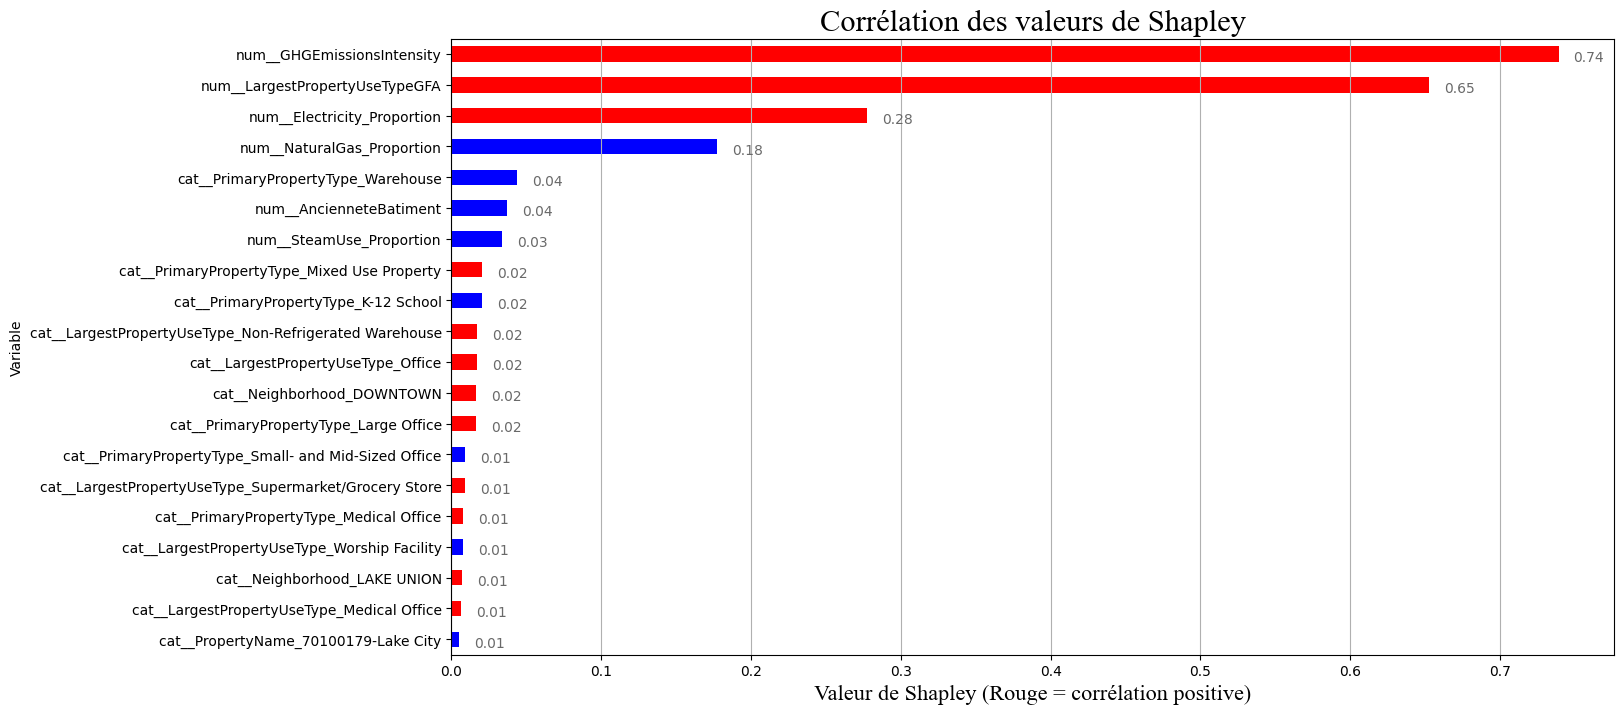

In [213]:
# Calcul des valeurs de Shapley des features 
X_test_transformed_df, shap_values_temp = feature_importance_globale(preprocessor, X_train_transformed, X_test_transformed, model=gb_best_model)

# Sauvegarde des données de test transformées et des valeurs de Shapley
shap_values["sans_ENERGYSTAR_incomplet"] = {}
shap_values["sans_ENERGYSTAR_incomplet"]["X_test_transformed_df"] = X_test_transformed_df
shap_values["sans_ENERGYSTAR_incomplet"]["shap_values"] = shap_values_temp

#### Locale

In [214]:
# Calcul de l'importance des caractéristiques par permutation
importance_locale_df['sans_ENERGYSTAR_incomplet'] = feature_importance_locale(gb_best_model, X_test_transformed_df, y_test, n_repeats=10, random_state=42, n_jobs=-1)

display(importance_locale_df['sans_ENERGYSTAR_incomplet'])

,feature,importance
2,num__GHGEmissionsIntensity,1.36124
1,num__LargestPropertyUseTypeGFA,0.97623
3,num__Electricity_Proportion,0.17612
5,num__NaturalGas_Proportion,0.07664
27,cat__PrimaryPropertyType_Warehouse,0.01226
6,num__AncienneteBatiment,0.00443
18,cat__PrimaryPropertyType_Mixed Use Property,0.00441
14,cat__PrimaryPropertyType_K-12 School,0.00320
4,num__SteamUse_Proportion,0.00237
866,cat__LargestPropertyUseType_Supermarket/Grocer...,0.00135


## <span style='background:green'>4/ Comparaison des résultats des différents dataset</span>

In [215]:
# transformation en df
resultats_dataset_diff_df = pd.DataFrame(resultats_dataset_diff).T
display(resultats_dataset_diff_df)

,mse_train,mse_test,rmse_train,rmse_test,r²_train,r²_test,temps_fit (sec),temps_predict (sec)
avec_ENERGYSTAR_imputé,0.01,0.09,0.1,0.30,0.99,0.95,2.10,0.02
sans_ENERGYSTAR_imputé,0.01,0.09,0.1,0.30,0.99,0.94,2.22,0.02
avec_ENERGYSTAR_incomplet,0.01,0.06,0.1,0.24,1.00,0.95,1.65,0.01
sans_ENERGYSTAR_incomplet,0.01,0.07,0.1,0.26,1.00,0.95,1.51,0.00


Nous comparons les résultats de performance des différents datasets.

#### RMSE

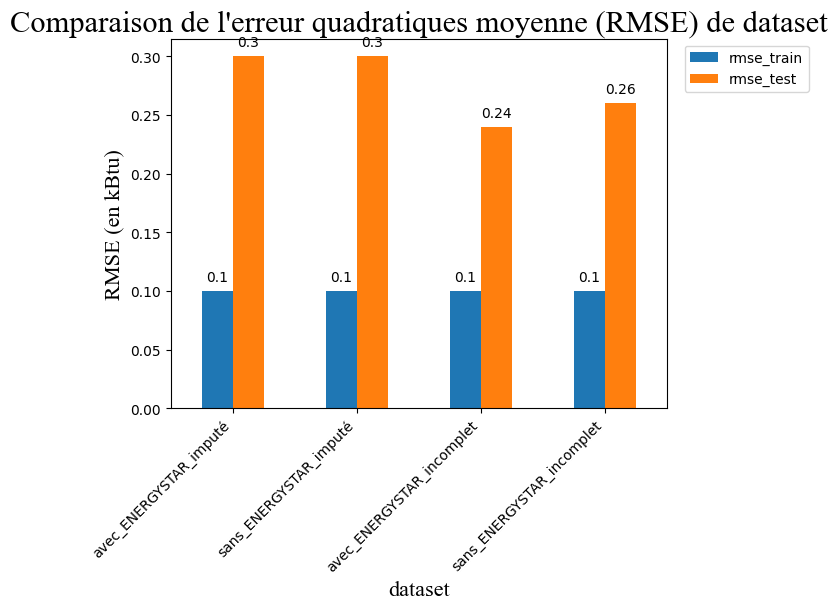

In [216]:
# Comparaison des RMSE des différents datasets
compare_perf(resultats_dataset_diff_df, "rmse", "dataset", font_title, font_axe, features=['rmse_train', 'rmse_test'])

Nous observons que la présence de la feature *ENERGY STAR Score* imputée n'impacte pas l'erreur du modèle. Elle diminue sensiblement l'erreur du modèle avec le dataset qui contient la feature **ENERGY STAR Score incomplet**. Cette dernère induit la plus petite erreur du modèle.

#### r²

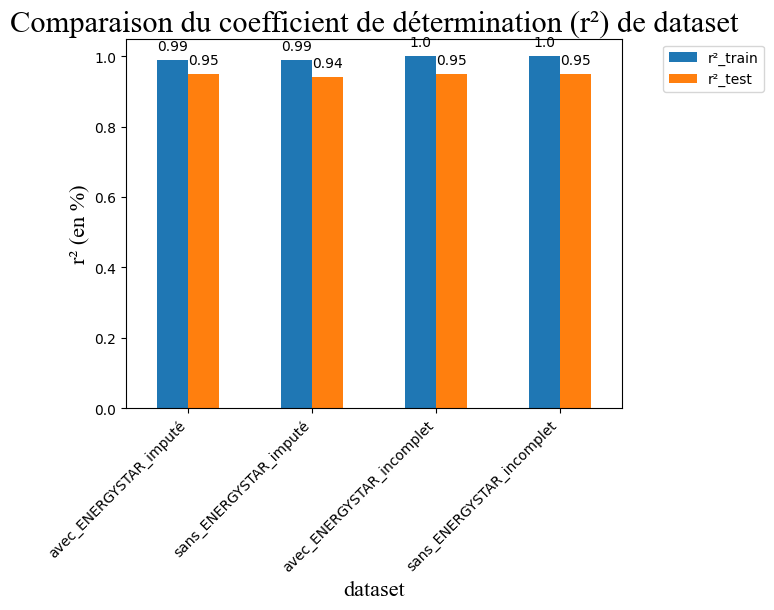

In [217]:
# Comparaison des r² des différents datasets
compare_perf(resultats_dataset_diff_df, "r²", "dataset", font_title, font_axe, features=['r²_train', 'r²_test'])

Nous observons que la présence de la feature *ENERGY STAR Score* imputée améliore sensiblement le r² du modèle. Nous pouvons toutefois noter que les r² sont très similaires.

#### Temps de calcul

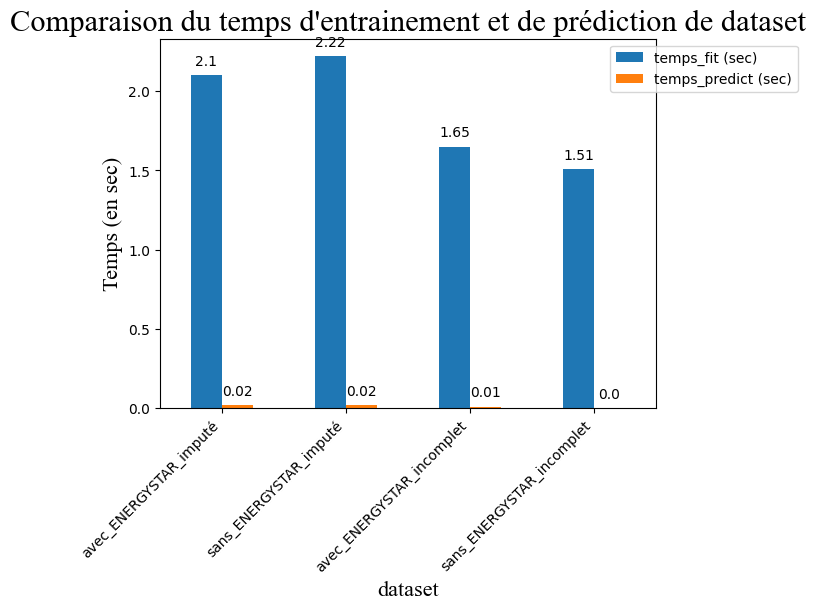

In [218]:
# Comparaison des temps de calcul des différents datasets
compare_perf(resultats_dataset_diff_df, "temps", "dataset", font_title, font_axe, features=['temps_fit (sec)', 'temps_predict (sec)'])

Nous remarquons que le temps d'entrainement est diminué par la présence de  l'*ENERGY STAR Score* imputée mais il est augmenté avec l'*ENERGY STAR Score* incomplet. Le temps d'entrainement qui est le plus faible est celui du dataset qui ne contient pas la feature **ENERGY STAR Score incomplète** (car il y a moins de ligne/bâtiment).

Concernant le temps de prédiction, il est similaire pour toutes les versions du dataset.

#### Feature importance globale

avec_ENERGYSTAR_imputé

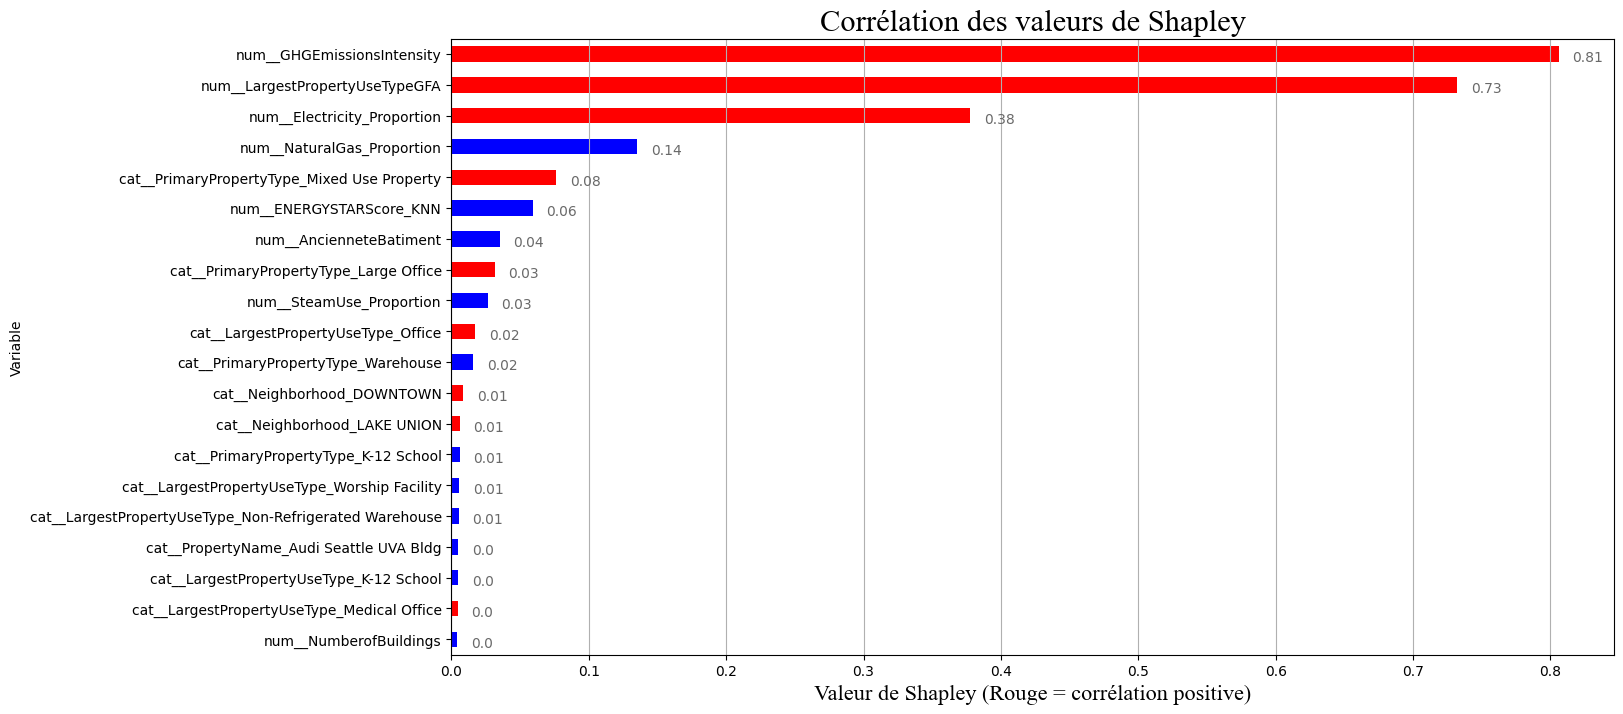

In [219]:
# Afficher les valeurs SHAP selon leur correlation avec la variable cible
shap_plot_avec_couleur(shap_values["avec_ENERGYSTAR_imputé"]["shap_values"], 
                    shap_values["avec_ENERGYSTAR_imputé"]["X_test_transformed_df"])

sans_ENERGYSTAR_imputé

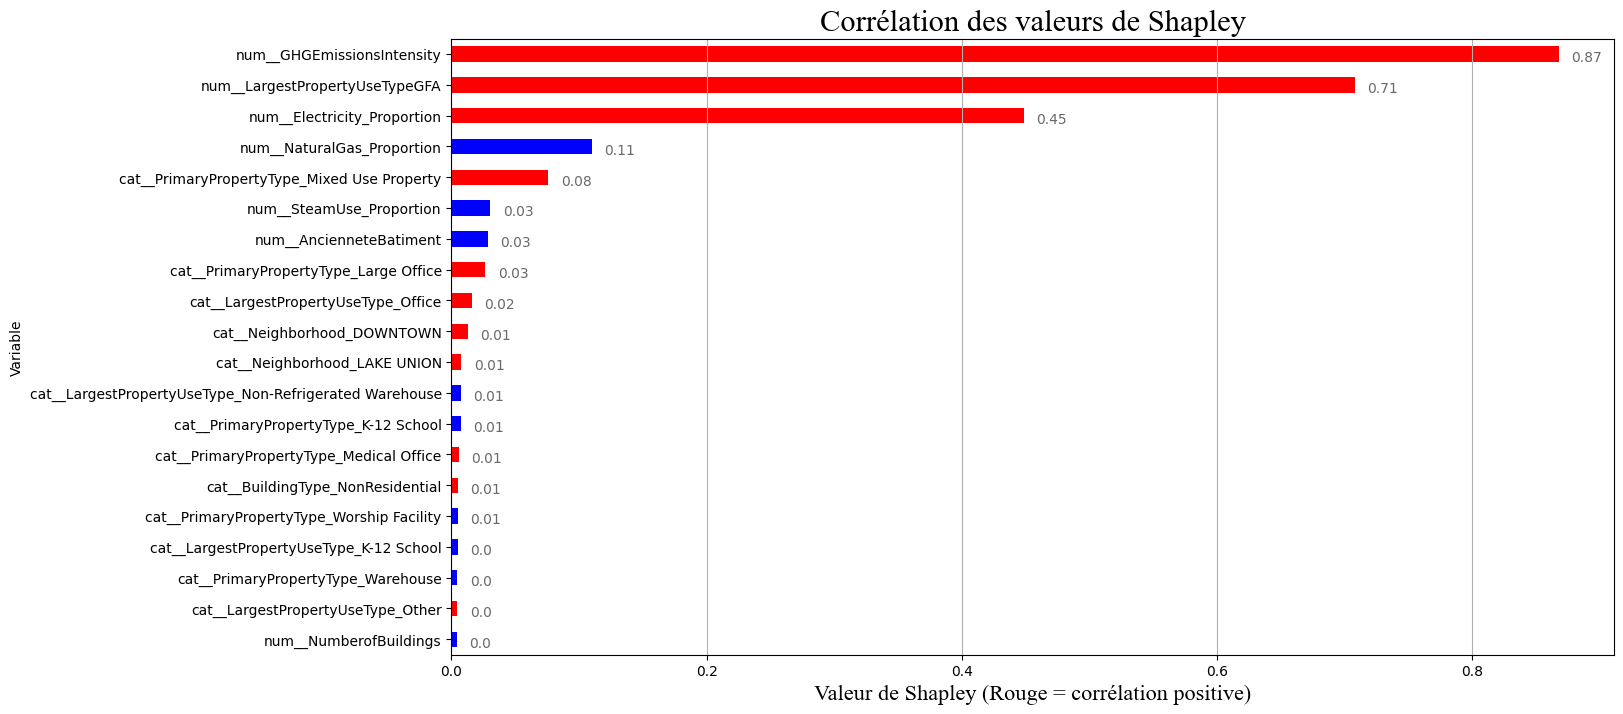

In [220]:
# Afficher les valeurs SHAP selon leur correlation avec la variable cible
shap_plot_avec_couleur(shap_values["sans_ENERGYSTAR_imputé"]["shap_values"], 
                    shap_values["sans_ENERGYSTAR_imputé"]["X_test_transformed_df"])

avec_ENERGYSTAR_incomplet

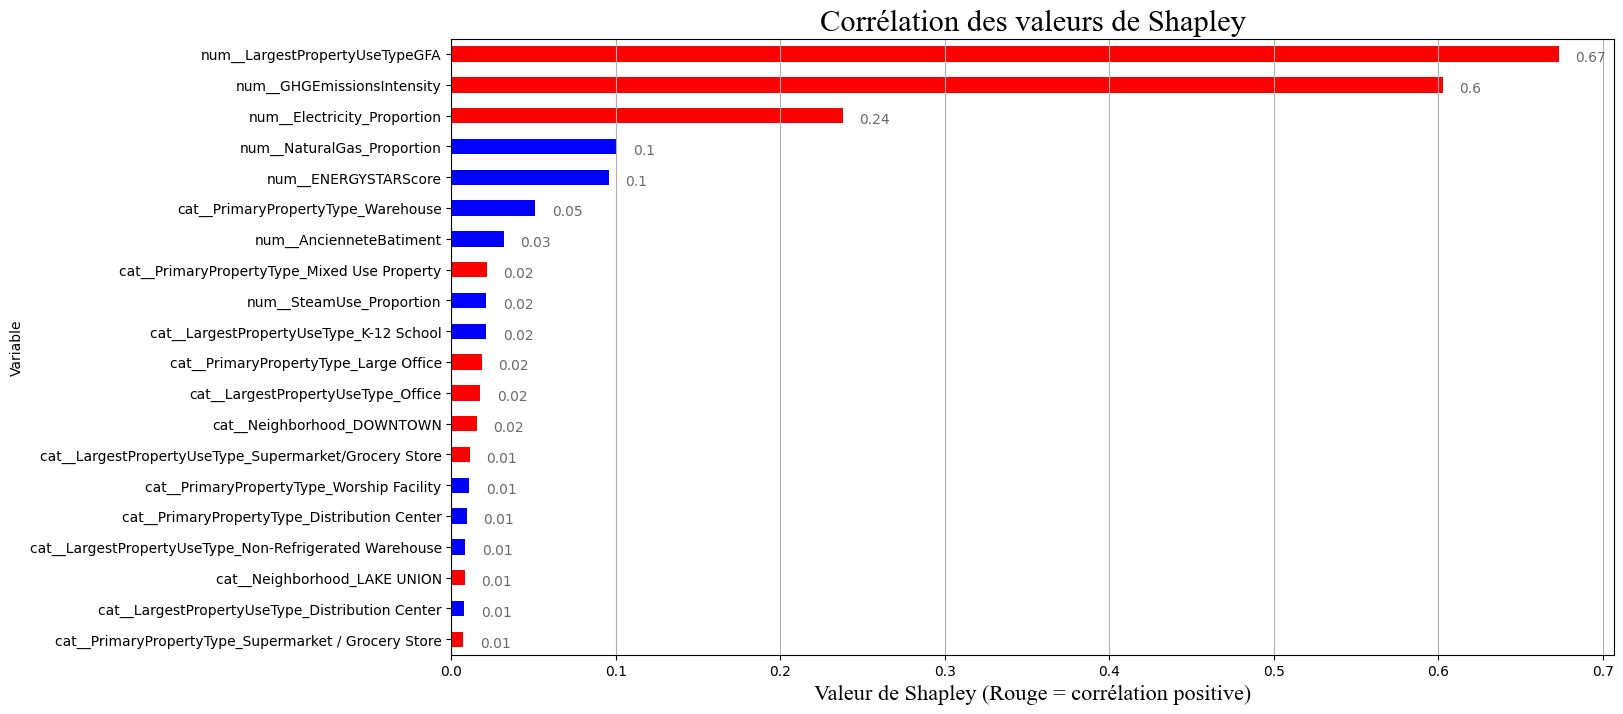

In [221]:
# Afficher les valeurs SHAP selon leur correlation avec la variable cible
shap_plot_avec_couleur(shap_values["avec_ENERGYSTAR_incomplet"]["shap_values"], 
                    shap_values["avec_ENERGYSTAR_incomplet"]["X_test_transformed_df"])

sans_ENERGYSTAR_incomplet

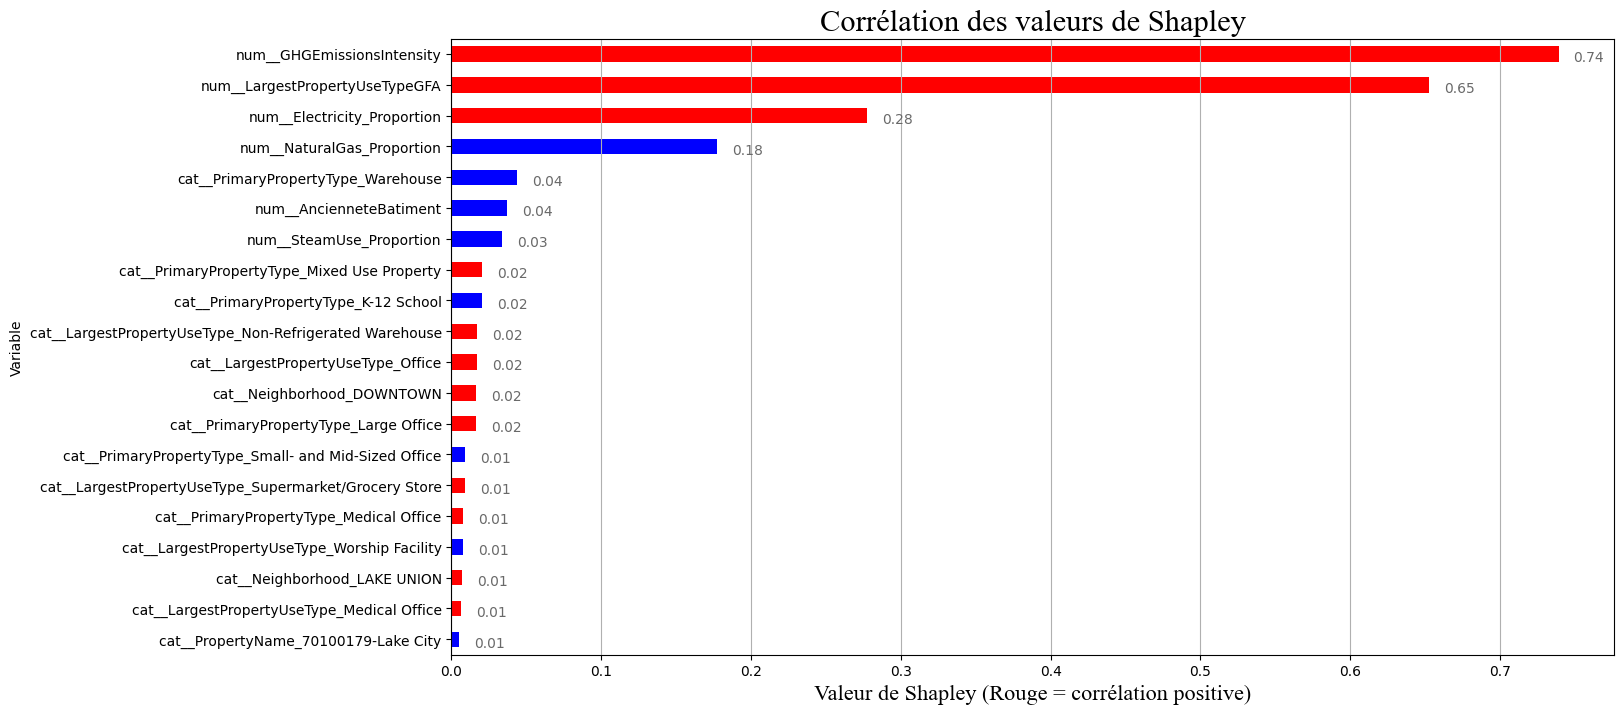

In [222]:
# Afficher les valeurs SHAP selon leur correlation avec la variable cible
shap_plot_avec_couleur(shap_values["sans_ENERGYSTAR_incomplet"]["shap_values"], 
                    shap_values["sans_ENERGYSTAR_incomplet"]["X_test_transformed_df"])

Nous observons 3 phénomènes notables :
- La suppression de la feature *ENERGY STAR Score* (imputée ou incomplète) augmente l'importance du ratio d'émission de CO2 / surface. 
  
- La suppression de la feature *ENERGY STAR Score* (imputée ou incomplète) impacte peu l'importance des 2 autres principales features, à savoir : 
  - la surface de type d'usage principal du batiment
  - La proportion d'énergie provenant de l'électricité
<br><br>
- La feature ENERGY STAR Score (imputée ou incomplète) impacte peu l'importance globale du modèle. En effet, cette feature se classe respectivement à la 6ème et 5ème position des features les plus importantes du modèle. 

#### Feature importance locale

avec_ENERGYSTAR_imputé

In [223]:
# Afficher uniquement les features importance locale > 0.05
filtered_df = importance_locale_df['avec_ENERGYSTAR_imputé'][importance_locale_df['avec_ENERGYSTAR_imputé']['importance'] > 0.05]

display(filtered_df)

,feature,importance
3,num__GHGEmissionsIntensity,1.24987
1,num__LargestPropertyUseTypeGFA,0.97696
4,num__Electricity_Proportion,0.22468


sans_ENERGYSTAR_imputé

In [224]:
# Afficher uniquement les features importance locale > 0.05
filtered_df = importance_locale_df['sans_ENERGYSTAR_imputé'][importance_locale_df['sans_ENERGYSTAR_imputé']['importance'] > 0.05]

display(filtered_df)

,feature,importance
2,num__GHGEmissionsIntensity,1.41537
1,num__LargestPropertyUseTypeGFA,0.93669
3,num__Electricity_Proportion,0.30126


avec_ENERGYSTAR_incomplet

In [225]:
# Afficher uniquement les features importance locale > 0.05
filtered_df = importance_locale_df['avec_ENERGYSTAR_incomplet'][importance_locale_df['avec_ENERGYSTAR_incomplet']['importance'] > 0.05]

display(filtered_df)

,feature,importance
1,num__LargestPropertyUseTypeGFA,1.04245
2,num__GHGEmissionsIntensity,0.95899
3,num__Electricity_Proportion,0.12122


sans_ENERGYSTAR_incomplet

In [226]:
# Afficher uniquement les features importance locale > 0.05
filtered_df = importance_locale_df['sans_ENERGYSTAR_incomplet'][importance_locale_df['sans_ENERGYSTAR_incomplet']['importance'] > 0.05]

display(filtered_df)

,feature,importance
2,num__GHGEmissionsIntensity,1.36124
1,num__LargestPropertyUseTypeGFA,0.97623
3,num__Electricity_Proportion,0.17612
5,num__NaturalGas_Proportion,0.07664


Nous observons 3 phénomènes notables :
- La présence du ENERGY STAR Score incomplet est la seule configuration qui induit la surface de type d'usage principal comme la feature la plus importante au niveau local.
<br><br>
- La suppression de la feature *ENERGY STAR Score* (imputée ou incomplète) induit systématiquement une augmentation de l'importance locale du ratio d'émission de CO2 / surface au dépend de l'importance locale de la surface de type d'usage principal qui diminue.
<br> <br>
- La feature ENERGY STAR Score (imputée et incomplète) n'impacte pas l'importance locale du modèle. 

# <span style='background:blue'>Etape 6 : Courbe d'apprentissage</span>

Nous affichons la courbe d'apprentissage du modèle XGBoosting selectionné, avec le dataset qui contient la feature ENERGY STAR Score incomplète puisque c'est avec celui-là que nous obtenons les résultats les plus intéressants. 

In [227]:
# Séparation des données avec ENERGYSTARScore incomplète
X_train, X_test, y_train, y_test = train_test_split(X_STAR_clean, y_clean, test_size=0.25, random_state=42)

# MAJ des features numériques et du preprocessor
numerical_features = X_STAR_clean.select_dtypes(include=['int64','float64']).columns

# MAJ du preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features), 
    ('cat', categorical_transformer, categorical_features)])

# Prétraitement des données d'entrainement
X_train_transformed = preprocessor.fit_transform(X_train)

# Meilleur modèle de GradientBoosting
model = gb_best_model

# Calculer la courbe d'apprentissage
train_sizes, train_mean, test_mean, train_std, test_std = calculer_courbe_apprentissage(model, X_train_transformed, y_train)

[learning_curve] Training set sizes: [ 72  85  98 111 124 138 151 164 177 191 204 217 230 243 257 270 283 296
 310 323 336 349 362 376 389 402 415 429 442 455 468 481 495 508 521 534
 548 561 574 587 600 614 627 640 653 667 680 693 706 720]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


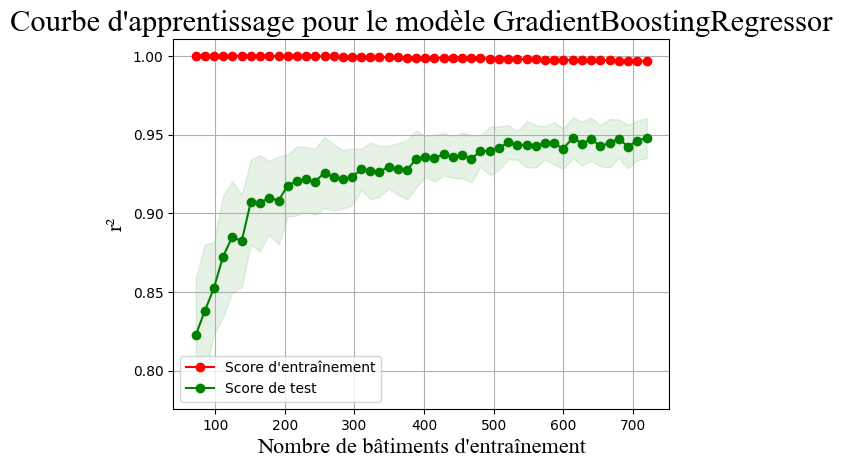

In [228]:
# Tracer la courbe d'apprentissage
tracer_courbe_apprentissage(train_sizes, train_mean, test_mean, train_std, test_std, model, font_title, font_axe)

Voici l'évolution du gap entre les performances du modèle sur le jeu d'entrainement et sur le jeu de test.

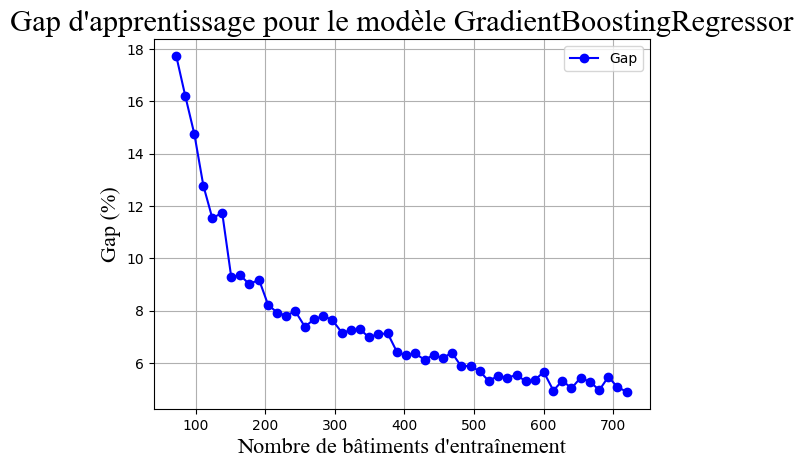

4.8959256023326425

In [229]:
# Calculer le gap d'apprentissage
gap = (train_mean - test_mean) / train_mean * 100

# Tracer le gap d'apprentissage
tracer_gap_apprentissage(train_sizes, gap, model, font_title, font_axe)

# Afficher le dernier gap d'apprentissage
display(gap[-1])

Nous remarquons que le r² du modèle sur le jeu de test se stabilise à partir de 600 batiments entrainés. Le r² obtenu par le modèle sur le jeu d'entrainement reste très proche de 1.00, tandis que celui sur le jeu de test se stabilise aux alentours de 0.95. Il y a un gap de 5% entre les deux r². 

# <span style='background:blue'>Conclusion</span>

Le modèle **GradientBoosting** a démontré les meilleurs performances pour la prédiction de la consommation totale d'énergie des batiments de la ville de Seattle. La configuration optimale de ses 4 hyperparamètres lui permette d'atteindre un **coefficient de détermination de 0,95** et **une erreur RMSE de 0,24 kBtu** sur le dataset comportant le score ENERGY STAR incomplet. 

Il y a 3 features qui présentent une importance élevée pour la prédiction. Il s'agit de la surface d'usage principal du bâtiment, du ratio d'émission de CO2 / surface et de la proportion d'énergie provenant de l'électricité.

**L'intérêt de l'ENERGY STAR Score** pour la prédiction de la quantité d'énergie consommée est vérifiée. L'utilisation de cette feature sous sa forme incomplète et non-imputée améliore légérement les performances du modèle, notamment en diminuant l'erreur de prédiction.

**Les performances du modèle sélectionné sont stables et acceptables pour pouvoir l'utiliser pour prédire la consommation totale d'énergie** des bâtiments de la ville de Seattle sans avoir besoin d'ajouter davantage de bâtiment.

____
Pour information, voici le temps qui a été nécessaire pour exécuter intégralement ce notebook :

In [230]:
# Calculer et afficher la durée totale
total_time = time.time() - start_time

# Convertir en minutes et secondes
minutes, seconds = divmod(total_time, 60)

# Afficher la durée totale
print("Durée totale pour faire tourner le notebook : {0} minute(s) {1} seconde(s)".format(int(minutes), int(seconds)))

Durée totale pour faire tourner le notebook : 17 minute(s) 43 seconde(s)
